In [1]:
import os

data_dir = '/home/steve/PycharmProjects/AI_Learning/Python深度学习/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


In [2]:
for item in header:
    print(item)
print(len(header))
print(len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"
15
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    print(i)
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i:] = values


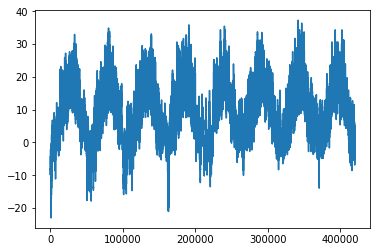

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)


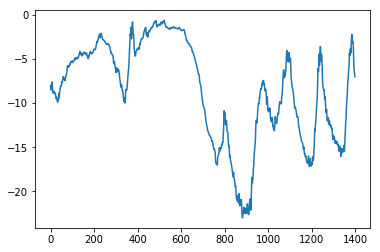

In [6]:
plt.plot(range(1400),temp[:1400])

In [28]:
new_float_data = float_data[:]
mean = new_float_data[:200000].mean(axis=0)
new_float_data -= mean
std = new_float_data[:200000].std(axis=0)
new_float_data /= std


In [29]:
new_float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [30]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(new_float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(new_float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(new_float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(new_float_data) - 300001 - lookback) // batch_size


In [37]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()


0.28973597299053566


In [38]:
celsius_mae = 0.29 * std[1]
celsius_mae


0.2900000000000129

In [39]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, new_float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20


  1/500 [..............................] - ETA: 11:42 - loss: 1.1867

  6/500 [..............................] - ETA: 2:00 - loss: 4.5330 

 13/500 [..............................] - ETA: 56s - loss: 3.8536 

 19/500 [>.............................] - ETA: 39s - loss: 3.3786

 25/500 [>.............................] - ETA: 30s - loss: 3.1415

 31/500 [>.............................] - ETA: 25s - loss: 2.9283

 36/500 [=>............................] - ETA: 22s - loss: 2.7829

 41/500 [=>............................] - ETA: 19s - loss: 2.6764

 47/500 [=>............................] - ETA: 17s - loss: 2.5694

 54/500 [==>...........................] - ETA: 15s - loss: 2.4835

 61/500 [==>...........................] - ETA: 14s - loss: 2.3868

 67/500 [===>..........................] - ETA: 12s - loss: 2.3090

 74/500 [===>..........................] - ETA: 11s - loss: 2.2545

 81/500 [===>..........................] - ETA: 10s - loss: 2.1984

 87/500 [====>.........................] - ETA: 10s - loss: 2.1473

 93/500 [====>.........................] - ETA: 9s - loss: 2.1003 

100/500 [=====>........................] - ETA: 9s - loss: 2.0636

107/500 [=====>........................] - ETA: 8s - loss: 2.0241

113/500 [=====>........................] - ETA: 8s - loss: 1.9971

119/500 [======>.......................] - ETA: 7s - loss: 1.9657

124/500 [======>.......................] - ETA: 7s - loss: 1.9379

130/500 [======>.......................] - ETA: 7s - loss: 1.9088

135/500 [=======>......................] - ETA: 7s - loss: 1.8866

141/500 [=======>......................] - ETA: 6s - loss: 1.8641

147/500 [=======>......................] - ETA: 6s - loss: 1.8388

153/500 [========>.....................] - ETA: 6s - loss: 1.8151

160/500 [========>.....................] - ETA: 5s - loss: 1.7936

167/500 [=========>....................] - ETA: 5s - loss: 1.7674

173/500 [=========>....................] - ETA: 5s - loss: 1.7489

180/500 [=========>....................] - ETA: 5s - loss: 1.7288

187/500 [==========>...................] - ETA: 5s - loss: 1.7064

193/500 [==========>...................] - ETA: 4s - loss: 1.6852

200/500 [===========>..................] - ETA: 4s - loss: 1.6659

206/500 [===========>..................] - ETA: 4s - loss: 1.6553

210/500 [===========>..................] - ETA: 4s - loss: 1.6439

217/500 [============>.................] - ETA: 4s - loss: 1.6265

224/500 [============>.................] - ETA: 4s - loss: 1.6108

230/500 [============>.................] - ETA: 4s - loss: 1.5959

237/500 [=============>................] - ETA: 3s - loss: 1.5777

243/500 [=============>................] - ETA: 3s - loss: 1.5631

249/500 [=============>................] - ETA: 3s - loss: 1.5479

256/500 [==============>...............] - ETA: 3s - loss: 1.5330

261/500 [==============>...............] - ETA: 3s - loss: 1.5223

267/500 [===============>..............] - ETA: 3s - loss: 1.5103

273/500 [===============>..............] - ETA: 3s - loss: 1.4985

279/500 [===============>..............] - ETA: 3s - loss: 1.4868

285/500 [================>.............] - ETA: 2s - loss: 1.4737

291/500 [================>.............] - ETA: 2s - loss: 1.4626

297/500 [================>.............] - ETA: 2s - loss: 1.4501

303/500 [=================>............] - ETA: 2s - loss: 1.4394

309/500 [=================>............] - ETA: 2s - loss: 1.4270

315/500 [=================>............] - ETA: 2s - loss: 1.4143

321/500 [==================>...........] - ETA: 2s - loss: 1.4048

327/500 [==================>...........] - ETA: 2s - loss: 1.3959

333/500 [==================>...........] - ETA: 2s - loss: 1.3869

338/500 [===================>..........] - ETA: 2s - loss: 1.3798

344/500 [===================>..........] - ETA: 2s - loss: 1.3689

350/500 [====================>.........] - ETA: 1s - loss: 1.3591

356/500 [====================>.........] - ETA: 1s - loss: 1.3505

362/500 [====================>.........] - ETA: 1s - loss: 1.3412

368/500 [=====================>........] - ETA: 1s - loss: 1.3317

374/500 [=====================>........] - ETA: 1s - loss: 1.3223

380/500 [=====================>........] - ETA: 1s - loss: 1.3152

385/500 [======================>.......] - ETA: 1s - loss: 1.3073

390/500 [======================>.......] - ETA: 1s - loss: 1.3001

396/500 [======================>.......] - ETA: 1s - loss: 1.2915

402/500 [=======================>......] - ETA: 1s - loss: 1.2841

408/500 [=======================>......] - ETA: 1s - loss: 1.2756

414/500 [=======================>......] - ETA: 1s - loss: 1.2670

420/500 [========================>.....] - ETA: 0s - loss: 1.2594

426/500 [========================>.....] - ETA: 0s - loss: 1.2513

432/500 [========================>.....] - ETA: 0s - loss: 1.2440

438/500 [=========================>....] - ETA: 0s - loss: 1.2367

444/500 [=========================>....] - ETA: 0s - loss: 1.2293

450/500 [==========================>...] - ETA: 0s - loss: 1.2207

457/500 [==========================>...] - ETA: 0s - loss: 1.2133

463/500 [==========================>...] - ETA: 0s - loss: 1.2066

469/500 [===========================>..] - ETA: 0s - loss: 1.1997

475/500 [===========================>..] - ETA: 0s - loss: 1.1930

481/500 [===========================>..] - ETA: 0s - loss: 1.1867

488/500 [============================>.] - ETA: 0s - loss: 1.1788

494/500 [============================>.] - ETA: 0s - loss: 1.1710

500/500 [==============================] - 11s 21ms/step - loss: 1.1655 - val_loss: 0.7133


Epoch 2/20
  1/500 [..............................] - ETA: 2s - loss: 0.6613

  8/500 [..............................] - ETA: 3s - loss: 0.6045

 16/500 [..............................] - ETA: 3s - loss: 0.5869

 19/500 [>.............................] - ETA: 4s - loss: 0.5943

 24/500 [>.............................] - ETA: 4s - loss: 0.6111

 30/500 [>.............................] - ETA: 4s - loss: 0.5865

 37/500 [=>............................] - ETA: 3s - loss: 0.5959

 43/500 [=>............................] - ETA: 3s - loss: 0.5891

 49/500 [=>............................] - ETA: 3s - loss: 0.5813

 55/500 [==>...........................] - ETA: 3s - loss: 0.5816

 61/500 [==>...........................] - ETA: 3s - loss: 0.5836

 68/500 [===>..........................] - ETA: 3s - loss: 0.5817

 73/500 [===>..........................] - ETA: 3s - loss: 0.5745

 79/500 [===>..........................] - ETA: 3s - loss: 0.5760

 85/500 [====>.........................] - ETA: 3s - loss: 0.5702

 91/500 [====>.........................] - ETA: 3s - loss: 0.5717

 97/500 [====>.........................] - ETA: 3s - loss: 0.5672

103/500 [=====>........................] - ETA: 3s - loss: 0.5670

108/500 [=====>........................] - ETA: 3s - loss: 0.5625

113/500 [=====>........................] - ETA: 3s - loss: 0.5586

119/500 [======>.......................] - ETA: 3s - loss: 0.5588

125/500 [======>.......................] - ETA: 3s - loss: 0.5554

131/500 [======>.......................] - ETA: 3s - loss: 0.5523

137/500 [=======>......................] - ETA: 3s - loss: 0.5512

143/500 [=======>......................] - ETA: 3s - loss: 0.5507

149/500 [=======>......................] - ETA: 3s - loss: 0.5481

155/500 [========>.....................] - ETA: 3s - loss: 0.5444

161/500 [========>.....................] - ETA: 3s - loss: 0.5401

166/500 [========>.....................] - ETA: 3s - loss: 0.5383

172/500 [=========>....................] - ETA: 2s - loss: 0.5360

179/500 [=========>....................] - ETA: 2s - loss: 0.5369

186/500 [==========>...................] - ETA: 2s - loss: 0.5341

192/500 [==========>...................] - ETA: 2s - loss: 0.5313

197/500 [==========>...................] - ETA: 2s - loss: 0.5301

202/500 [===========>..................] - ETA: 2s - loss: 0.5271

207/500 [===========>..................] - ETA: 2s - loss: 0.5253

212/500 [===========>..................] - ETA: 2s - loss: 0.5236

217/500 [============>.................] - ETA: 2s - loss: 0.5233

221/500 [============>.................] - ETA: 2s - loss: 0.5206

226/500 [============>.................] - ETA: 2s - loss: 0.5184

231/500 [============>.................] - ETA: 2s - loss: 0.5168

235/500 [=============>................] - ETA: 2s - loss: 0.5150

240/500 [=============>................] - ETA: 2s - loss: 0.5146

245/500 [=============>................] - ETA: 2s - loss: 0.5126

250/500 [==============>...............] - ETA: 2s - loss: 0.5114

255/500 [==============>...............] - ETA: 2s - loss: 0.5090

260/500 [==============>...............] - ETA: 2s - loss: 0.5078

265/500 [==============>...............] - ETA: 2s - loss: 0.5063

269/500 [===============>..............] - ETA: 2s - loss: 0.5044

272/500 [===============>..............] - ETA: 2s - loss: 0.5030

276/500 [===============>..............] - ETA: 2s - loss: 0.5020

280/500 [===============>..............] - ETA: 2s - loss: 0.5003

283/500 [===============>..............] - ETA: 2s - loss: 0.4998

286/500 [================>.............] - ETA: 2s - loss: 0.4991

290/500 [================>.............] - ETA: 2s - loss: 0.4969

293/500 [================>.............] - ETA: 2s - loss: 0.4951

296/500 [================>.............] - ETA: 2s - loss: 0.4948

300/500 [=================>............] - ETA: 2s - loss: 0.4940

305/500 [=================>............] - ETA: 2s - loss: 0.4923

310/500 [=================>............] - ETA: 2s - loss: 0.4899

316/500 [=================>............] - ETA: 1s - loss: 0.4891

320/500 [==================>...........] - ETA: 1s - loss: 0.4877

325/500 [==================>...........] - ETA: 1s - loss: 0.4862

330/500 [==================>...........] - ETA: 1s - loss: 0.4839

333/500 [==================>...........] - ETA: 1s - loss: 0.4836

336/500 [===================>..........] - ETA: 1s - loss: 0.4830

339/500 [===================>..........] - ETA: 1s - loss: 0.4823

342/500 [===================>..........] - ETA: 1s - loss: 0.4817

345/500 [===================>..........] - ETA: 1s - loss: 0.4811

348/500 [===================>..........] - ETA: 1s - loss: 0.4804

352/500 [====================>.........] - ETA: 1s - loss: 0.4790

355/500 [====================>.........] - ETA: 1s - loss: 0.4781

358/500 [====================>.........] - ETA: 1s - loss: 0.4773

361/500 [====================>.........] - ETA: 1s - loss: 0.4769

365/500 [====================>.........] - ETA: 1s - loss: 0.4762

368/500 [=====================>........] - ETA: 1s - loss: 0.4754

371/500 [=====================>........] - ETA: 1s - loss: 0.4739

375/500 [=====================>........] - ETA: 1s - loss: 0.4725

378/500 [=====================>........] - ETA: 1s - loss: 0.4713

382/500 [=====================>........] - ETA: 1s - loss: 0.4710

385/500 [======================>.......] - ETA: 1s - loss: 0.4707

389/500 [======================>.......] - ETA: 1s - loss: 0.4700

392/500 [======================>.......] - ETA: 1s - loss: 0.4692

396/500 [======================>.......] - ETA: 1s - loss: 0.4680

400/500 [=======================>......] - ETA: 1s - loss: 0.4668

404/500 [=======================>......] - ETA: 1s - loss: 0.4656

407/500 [=======================>......] - ETA: 1s - loss: 0.4645

410/500 [=======================>......] - ETA: 1s - loss: 0.4646

413/500 [=======================>......] - ETA: 1s - loss: 0.4641

417/500 [========================>.....] - ETA: 1s - loss: 0.4631

420/500 [========================>.....] - ETA: 0s - loss: 0.4625

424/500 [========================>.....] - ETA: 0s - loss: 0.4618

428/500 [========================>.....] - ETA: 0s - loss: 0.4606

432/500 [========================>.....] - ETA: 0s - loss: 0.4599

436/500 [=========================>....] - ETA: 0s - loss: 0.4587

440/500 [=========================>....] - ETA: 0s - loss: 0.4580

444/500 [=========================>....] - ETA: 0s - loss: 0.4570

448/500 [=========================>....] - ETA: 0s - loss: 0.4561

452/500 [==========================>...] - ETA: 0s - loss: 0.4552

455/500 [==========================>...] - ETA: 0s - loss: 0.4544

458/500 [==========================>...] - ETA: 0s - loss: 0.4540

462/500 [==========================>...] - ETA: 0s - loss: 0.4530

465/500 [==========================>...] - ETA: 0s - loss: 0.4524

469/500 [===========================>..] - ETA: 0s - loss: 0.4514

473/500 [===========================>..] - ETA: 0s - loss: 0.4509

477/500 [===========================>..] - ETA: 0s - loss: 0.4498

481/500 [===========================>..] - ETA: 0s - loss: 0.4487

485/500 [============================>.] - ETA: 0s - loss: 0.4479

489/500 [============================>.] - ETA: 0s - loss: 0.4470

494/500 [============================>.] - ETA: 0s - loss: 0.4463

499/500 [============================>.] - ETA: 0s - loss: 0.4455

500/500 [==============================] - 11s 23ms/step - loss: 0.4454 - val_loss: 0.3864


Epoch 3/20
  1/500 [..............................] - ETA: 5s - loss: 0.2955

  6/500 [..............................] - ETA: 5s - loss: 0.3463

 15/500 [..............................] - ETA: 3s - loss: 0.3294

 19/500 [>.............................] - ETA: 4s - loss: 0.3244

 23/500 [>.............................] - ETA: 4s - loss: 0.3287

 29/500 [>.............................] - ETA: 4s - loss: 0.3227

 35/500 [=>............................] - ETA: 4s - loss: 0.3249

 41/500 [=>............................] - ETA: 4s - loss: 0.3235

 47/500 [=>............................] - ETA: 4s - loss: 0.3258

 52/500 [==>...........................] - ETA: 4s - loss: 0.3261

 57/500 [==>...........................] - ETA: 4s - loss: 0.3257

 63/500 [==>...........................] - ETA: 4s - loss: 0.3252

 69/500 [===>..........................] - ETA: 4s - loss: 0.3242

 75/500 [===>..........................] - ETA: 4s - loss: 0.3242

 81/500 [===>..........................] - ETA: 4s - loss: 0.3254

 87/500 [====>.........................] - ETA: 3s - loss: 0.3253

 93/500 [====>.........................] - ETA: 3s - loss: 0.3230

 99/500 [====>.........................] - ETA: 3s - loss: 0.3209

105/500 [=====>........................] - ETA: 3s - loss: 0.3228

111/500 [=====>........................] - ETA: 3s - loss: 0.3203

117/500 [======>.......................] - ETA: 3s - loss: 0.3196

123/500 [======>.......................] - ETA: 3s - loss: 0.3176

129/500 [======>.......................] - ETA: 3s - loss: 0.3183

135/500 [=======>......................] - ETA: 3s - loss: 0.3178

140/500 [=======>......................] - ETA: 3s - loss: 0.3182

146/500 [=======>......................] - ETA: 3s - loss: 0.3170

152/500 [========>.....................] - ETA: 3s - loss: 0.3175

157/500 [========>.....................] - ETA: 3s - loss: 0.3160

162/500 [========>.....................] - ETA: 3s - loss: 0.3160

168/500 [=========>....................] - ETA: 3s - loss: 0.3168

174/500 [=========>....................] - ETA: 3s - loss: 0.3161

180/500 [=========>....................] - ETA: 3s - loss: 0.3158

186/500 [==========>...................] - ETA: 2s - loss: 0.3159

192/500 [==========>...................] - ETA: 2s - loss: 0.3147

198/500 [==========>...................] - ETA: 2s - loss: 0.3136

204/500 [===========>..................] - ETA: 2s - loss: 0.3129

210/500 [===========>..................] - ETA: 2s - loss: 0.3122

216/500 [===========>..................] - ETA: 2s - loss: 0.3123

222/500 [============>.................] - ETA: 2s - loss: 0.3117

228/500 [============>.................] - ETA: 2s - loss: 0.3114

234/500 [=============>................] - ETA: 2s - loss: 0.3105

239/500 [=============>................] - ETA: 2s - loss: 0.3102

245/500 [=============>................] - ETA: 2s - loss: 0.3098

251/500 [==============>...............] - ETA: 2s - loss: 0.3098

257/500 [==============>...............] - ETA: 2s - loss: 0.3094

263/500 [==============>...............] - ETA: 2s - loss: 0.3088

269/500 [===============>..............] - ETA: 2s - loss: 0.3085

275/500 [===============>..............] - ETA: 2s - loss: 0.3083

281/500 [===============>..............] - ETA: 2s - loss: 0.3086

287/500 [================>.............] - ETA: 2s - loss: 0.3080

293/500 [================>.............] - ETA: 1s - loss: 0.3073

298/500 [================>.............] - ETA: 1s - loss: 0.3066

304/500 [=================>............] - ETA: 1s - loss: 0.3066

310/500 [=================>............] - ETA: 1s - loss: 0.3060

317/500 [==================>...........] - ETA: 1s - loss: 0.3055

323/500 [==================>...........] - ETA: 1s - loss: 0.3052

328/500 [==================>...........] - ETA: 1s - loss: 0.3050

333/500 [==================>...........] - ETA: 1s - loss: 0.3047

338/500 [===================>..........] - ETA: 1s - loss: 0.3047

343/500 [===================>..........] - ETA: 1s - loss: 0.3043

348/500 [===================>..........] - ETA: 1s - loss: 0.3038

352/500 [====================>.........] - ETA: 1s - loss: 0.3034

357/500 [====================>.........] - ETA: 1s - loss: 0.3035

362/500 [====================>.........] - ETA: 1s - loss: 0.3035

367/500 [=====================>........] - ETA: 1s - loss: 0.3032

372/500 [=====================>........] - ETA: 1s - loss: 0.3028

377/500 [=====================>........] - ETA: 1s - loss: 0.3025

383/500 [=====================>........] - ETA: 1s - loss: 0.3022

389/500 [======================>.......] - ETA: 1s - loss: 0.3023

396/500 [======================>.......] - ETA: 0s - loss: 0.3020

402/500 [=======================>......] - ETA: 0s - loss: 0.3016

408/500 [=======================>......] - ETA: 0s - loss: 0.3013

414/500 [=======================>......] - ETA: 0s - loss: 0.3010

420/500 [========================>.....] - ETA: 0s - loss: 0.3008

426/500 [========================>.....] - ETA: 0s - loss: 0.3008

432/500 [========================>.....] - ETA: 0s - loss: 0.3003

438/500 [=========================>....] - ETA: 0s - loss: 0.3000

444/500 [=========================>....] - ETA: 0s - loss: 0.2997

451/500 [==========================>...] - ETA: 0s - loss: 0.2996

457/500 [==========================>...] - ETA: 0s - loss: 0.2990

463/500 [==========================>...] - ETA: 0s - loss: 0.2987

469/500 [===========================>..] - ETA: 0s - loss: 0.2984

475/500 [===========================>..] - ETA: 0s - loss: 0.2981

481/500 [===========================>..] - ETA: 0s - loss: 0.2981

487/500 [============================>.] - ETA: 0s - loss: 0.2979

493/500 [============================>.] - ETA: 0s - loss: 0.2976

499/500 [============================>.] - ETA: 0s - loss: 0.2975

500/500 [==============================] - 11s 22ms/step - loss: 0.2974 - val_loss: 0.3196


Epoch 4/20
  1/500 [..............................] - ETA: 3s - loss: 0.2843

  6/500 [..............................] - ETA: 4s - loss: 0.2793

 11/500 [..............................] - ETA: 5s - loss: 0.2855

 16/500 [..............................] - ETA: 5s - loss: 0.2836

 19/500 [>.............................] - ETA: 5s - loss: 0.2811

 23/500 [>.............................] - ETA: 6s - loss: 0.2772

 27/500 [>.............................] - ETA: 6s - loss: 0.2733

 31/500 [>.............................] - ETA: 6s - loss: 0.2773

 35/500 [=>............................] - ETA: 6s - loss: 0.2774

 39/500 [=>............................] - ETA: 6s - loss: 0.2757

 44/500 [=>............................] - ETA: 6s - loss: 0.2776

 49/500 [=>............................] - ETA: 6s - loss: 0.2796

 53/500 [==>...........................] - ETA: 5s - loss: 0.2786

 57/500 [==>...........................] - ETA: 5s - loss: 0.2780

 62/500 [==>...........................] - ETA: 5s - loss: 0.2760

 67/500 [===>..........................] - ETA: 5s - loss: 0.2757

 71/500 [===>..........................] - ETA: 5s - loss: 0.2738

 75/500 [===>..........................] - ETA: 5s - loss: 0.2737

 79/500 [===>..........................] - ETA: 5s - loss: 0.2741

 83/500 [===>..........................] - ETA: 5s - loss: 0.2745

 87/500 [====>.........................] - ETA: 5s - loss: 0.2739

 92/500 [====>.........................] - ETA: 5s - loss: 0.2733

 96/500 [====>.........................] - ETA: 5s - loss: 0.2734

101/500 [=====>........................] - ETA: 5s - loss: 0.2731

105/500 [=====>........................] - ETA: 5s - loss: 0.2751

109/500 [=====>........................] - ETA: 5s - loss: 0.2748

114/500 [=====>........................] - ETA: 5s - loss: 0.2746

118/500 [======>.......................] - ETA: 5s - loss: 0.2747

122/500 [======>.......................] - ETA: 5s - loss: 0.2744

126/500 [======>.......................] - ETA: 4s - loss: 0.2739

131/500 [======>.......................] - ETA: 4s - loss: 0.2738

136/500 [=======>......................] - ETA: 4s - loss: 0.2732

141/500 [=======>......................] - ETA: 4s - loss: 0.2734

146/500 [=======>......................] - ETA: 4s - loss: 0.2732

151/500 [========>.....................] - ETA: 4s - loss: 0.2733

156/500 [========>.....................] - ETA: 4s - loss: 0.2732

161/500 [========>.....................] - ETA: 4s - loss: 0.2728

166/500 [========>.....................] - ETA: 4s - loss: 0.2728

172/500 [=========>....................] - ETA: 4s - loss: 0.2729

177/500 [=========>....................] - ETA: 4s - loss: 0.2735

182/500 [=========>....................] - ETA: 4s - loss: 0.2735

187/500 [==========>...................] - ETA: 3s - loss: 0.2731

191/500 [==========>...................] - ETA: 3s - loss: 0.2729

196/500 [==========>...................] - ETA: 3s - loss: 0.2731

201/500 [===========>..................] - ETA: 3s - loss: 0.2726

207/500 [===========>..................] - ETA: 3s - loss: 0.2722

212/500 [===========>..................] - ETA: 3s - loss: 0.2719

218/500 [============>.................] - ETA: 3s - loss: 0.2719

224/500 [============>.................] - ETA: 3s - loss: 0.2721

230/500 [============>.................] - ETA: 3s - loss: 0.2723

235/500 [=============>................] - ETA: 3s - loss: 0.2724

241/500 [=============>................] - ETA: 3s - loss: 0.2722

247/500 [=============>................] - ETA: 3s - loss: 0.2728

253/500 [==============>...............] - ETA: 2s - loss: 0.2726

259/500 [==============>...............] - ETA: 2s - loss: 0.2726

265/500 [==============>...............] - ETA: 2s - loss: 0.2725

271/500 [===============>..............] - ETA: 2s - loss: 0.2723

277/500 [===============>..............] - ETA: 2s - loss: 0.2720

283/500 [===============>..............] - ETA: 2s - loss: 0.2718

290/500 [================>.............] - ETA: 2s - loss: 0.2717

296/500 [================>.............] - ETA: 2s - loss: 0.2712

302/500 [=================>............] - ETA: 2s - loss: 0.2713

308/500 [=================>............] - ETA: 2s - loss: 0.2710

315/500 [=================>............] - ETA: 2s - loss: 0.2709

322/500 [==================>...........] - ETA: 1s - loss: 0.2710

328/500 [==================>...........] - ETA: 1s - loss: 0.2709

334/500 [===================>..........] - ETA: 1s - loss: 0.2707

340/500 [===================>..........] - ETA: 1s - loss: 0.2705

346/500 [===================>..........] - ETA: 1s - loss: 0.2703

352/500 [====================>.........] - ETA: 1s - loss: 0.2698

358/500 [====================>.........] - ETA: 1s - loss: 0.2699

364/500 [====================>.........] - ETA: 1s - loss: 0.2699

370/500 [=====================>........] - ETA: 1s - loss: 0.2699

376/500 [=====================>........] - ETA: 1s - loss: 0.2696

382/500 [=====================>........] - ETA: 1s - loss: 0.2693

387/500 [======================>.......] - ETA: 1s - loss: 0.2688

393/500 [======================>.......] - ETA: 1s - loss: 0.2687

399/500 [======================>.......] - ETA: 1s - loss: 0.2686

405/500 [=======================>......] - ETA: 1s - loss: 0.2688

411/500 [=======================>......] - ETA: 0s - loss: 0.2688

416/500 [=======================>......] - ETA: 0s - loss: 0.2687

422/500 [========================>.....] - ETA: 0s - loss: 0.2687

428/500 [========================>.....] - ETA: 0s - loss: 0.2686

434/500 [=========================>....] - ETA: 0s - loss: 0.2686

440/500 [=========================>....] - ETA: 0s - loss: 0.2684

446/500 [=========================>....] - ETA: 0s - loss: 0.2684

452/500 [==========================>...] - ETA: 0s - loss: 0.2682

458/500 [==========================>...] - ETA: 0s - loss: 0.2682

465/500 [==========================>...] - ETA: 0s - loss: 0.2682

471/500 [===========================>..] - ETA: 0s - loss: 0.2681

477/500 [===========================>..] - ETA: 0s - loss: 0.2678

483/500 [===========================>..] - ETA: 0s - loss: 0.2679

489/500 [============================>.] - ETA: 0s - loss: 0.2678

495/500 [============================>.] - ETA: 0s - loss: 0.2677

500/500 [==============================] - 11s 22ms/step - loss: 0.2674 - val_loss: 0.3175


Epoch 5/20
  1/500 [..............................] - ETA: 2s - loss: 0.2343

  6/500 [..............................] - ETA: 4s - loss: 0.2927

 15/500 [..............................] - ETA: 3s - loss: 0.2661

 19/500 [>.............................] - ETA: 4s - loss: 0.2681

 23/500 [>.............................] - ETA: 4s - loss: 0.2653

 29/500 [>.............................] - ETA: 4s - loss: 0.2648

 35/500 [=>............................] - ETA: 4s - loss: 0.2628

 41/500 [=>............................] - ETA: 4s - loss: 0.2635

 47/500 [=>............................] - ETA: 4s - loss: 0.2652

 53/500 [==>...........................] - ETA: 4s - loss: 0.2645

 60/500 [==>...........................] - ETA: 3s - loss: 0.2639

 66/500 [==>...........................] - ETA: 3s - loss: 0.2663

 71/500 [===>..........................] - ETA: 3s - loss: 0.2655

 77/500 [===>..........................] - ETA: 3s - loss: 0.2659

 83/500 [===>..........................] - ETA: 3s - loss: 0.2644

 89/500 [====>.........................] - ETA: 3s - loss: 0.2624

 95/500 [====>.........................] - ETA: 3s - loss: 0.2619

101/500 [=====>........................] - ETA: 3s - loss: 0.2609

107/500 [=====>........................] - ETA: 3s - loss: 0.2602

113/500 [=====>........................] - ETA: 3s - loss: 0.2614

119/500 [======>.......................] - ETA: 3s - loss: 0.2618

125/500 [======>.......................] - ETA: 3s - loss: 0.2624

131/500 [======>.......................] - ETA: 3s - loss: 0.2622

137/500 [=======>......................] - ETA: 3s - loss: 0.2626

143/500 [=======>......................] - ETA: 3s - loss: 0.2625

149/500 [=======>......................] - ETA: 3s - loss: 0.2626

156/500 [========>.....................] - ETA: 3s - loss: 0.2623

162/500 [========>.....................] - ETA: 3s - loss: 0.2617

168/500 [=========>....................] - ETA: 2s - loss: 0.2617

174/500 [=========>....................] - ETA: 2s - loss: 0.2612

180/500 [=========>....................] - ETA: 2s - loss: 0.2609

186/500 [==========>...................] - ETA: 2s - loss: 0.2606

191/500 [==========>...................] - ETA: 2s - loss: 0.2611

197/500 [==========>...................] - ETA: 2s - loss: 0.2603

203/500 [===========>..................] - ETA: 2s - loss: 0.2605

209/500 [===========>..................] - ETA: 2s - loss: 0.2601

215/500 [===========>..................] - ETA: 2s - loss: 0.2597

221/500 [============>.................] - ETA: 2s - loss: 0.2595

227/500 [============>.................] - ETA: 2s - loss: 0.2597

233/500 [============>.................] - ETA: 2s - loss: 0.2592

239/500 [=============>................] - ETA: 2s - loss: 0.2592

245/500 [=============>................] - ETA: 2s - loss: 0.2590

251/500 [==============>...............] - ETA: 2s - loss: 0.2596

255/500 [==============>...............] - ETA: 2s - loss: 0.2593

260/500 [==============>...............] - ETA: 2s - loss: 0.2589

266/500 [==============>...............] - ETA: 2s - loss: 0.2593

272/500 [===============>..............] - ETA: 2s - loss: 0.2594

278/500 [===============>..............] - ETA: 2s - loss: 0.2589

284/500 [================>.............] - ETA: 1s - loss: 0.2590

289/500 [================>.............] - ETA: 1s - loss: 0.2592

295/500 [================>.............] - ETA: 1s - loss: 0.2590

299/500 [================>.............] - ETA: 1s - loss: 0.2590

305/500 [=================>............] - ETA: 1s - loss: 0.2588

311/500 [=================>............] - ETA: 1s - loss: 0.2586

317/500 [==================>...........] - ETA: 1s - loss: 0.2584

323/500 [==================>...........] - ETA: 1s - loss: 0.2587

330/500 [==================>...........] - ETA: 1s - loss: 0.2585

336/500 [===================>..........] - ETA: 1s - loss: 0.2584

342/500 [===================>..........] - ETA: 1s - loss: 0.2583

347/500 [===================>..........] - ETA: 1s - loss: 0.2584

353/500 [====================>.........] - ETA: 1s - loss: 0.2581

358/500 [====================>.........] - ETA: 1s - loss: 0.2580

363/500 [====================>.........] - ETA: 1s - loss: 0.2579

368/500 [=====================>........] - ETA: 1s - loss: 0.2577

373/500 [=====================>........] - ETA: 1s - loss: 0.2576

378/500 [=====================>........] - ETA: 1s - loss: 0.2575

382/500 [=====================>........] - ETA: 1s - loss: 0.2575

386/500 [======================>.......] - ETA: 1s - loss: 0.2574

389/500 [======================>.......] - ETA: 1s - loss: 0.2573

392/500 [======================>.......] - ETA: 1s - loss: 0.2573

396/500 [======================>.......] - ETA: 0s - loss: 0.2573

401/500 [=======================>......] - ETA: 0s - loss: 0.2572

405/500 [=======================>......] - ETA: 0s - loss: 0.2570

409/500 [=======================>......] - ETA: 0s - loss: 0.2568

413/500 [=======================>......] - ETA: 0s - loss: 0.2567

417/500 [========================>.....] - ETA: 0s - loss: 0.2567

422/500 [========================>.....] - ETA: 0s - loss: 0.2567

426/500 [========================>.....] - ETA: 0s - loss: 0.2567

431/500 [========================>.....] - ETA: 0s - loss: 0.2568

437/500 [=========================>....] - ETA: 0s - loss: 0.2567

443/500 [=========================>....] - ETA: 0s - loss: 0.2568

449/500 [=========================>....] - ETA: 0s - loss: 0.2567

455/500 [==========================>...] - ETA: 0s - loss: 0.2568

461/500 [==========================>...] - ETA: 0s - loss: 0.2567

467/500 [===========================>..] - ETA: 0s - loss: 0.2566

472/500 [===========================>..] - ETA: 0s - loss: 0.2566

476/500 [===========================>..] - ETA: 0s - loss: 0.2564

481/500 [===========================>..] - ETA: 0s - loss: 0.2564

486/500 [============================>.] - ETA: 0s - loss: 0.2565

490/500 [============================>.] - ETA: 0s - loss: 0.2564

494/500 [============================>.] - ETA: 0s - loss: 0.2563

499/500 [============================>.] - ETA: 0s - loss: 0.2564

500/500 [==============================] - 12s 24ms/step - loss: 0.2564 - val_loss: 0.3044


Epoch 6/20
  1/500 [..............................] - ETA: 8s - loss: 0.2348

  5/500 [..............................] - ETA: 7s - loss: 0.2475

  9/500 [..............................] - ETA: 7s - loss: 0.2618

 12/500 [..............................] - ETA: 7s - loss: 0.2630

 15/500 [..............................] - ETA: 8s - loss: 0.2650

 16/500 [..............................] - ETA: 10s - loss: 0.2638

 18/500 [>.............................] - ETA: 10s - loss: 0.2606

 20/500 [>.............................] - ETA: 11s - loss: 0.2569

 22/500 [>.............................] - ETA: 11s - loss: 0.2589

 25/500 [>.............................] - ETA: 11s - loss: 0.2626

 28/500 [>.............................] - ETA: 11s - loss: 0.2606

 31/500 [>.............................] - ETA: 11s - loss: 0.2600

 34/500 [=>............................] - ETA: 10s - loss: 0.2580

 36/500 [=>............................] - ETA: 10s - loss: 0.2571

 39/500 [=>............................] - ETA: 10s - loss: 0.2559

 42/500 [=>............................] - ETA: 10s - loss: 0.2539

 46/500 [=>............................] - ETA: 10s - loss: 0.2520

 49/500 [=>............................] - ETA: 10s - loss: 0.2517

 52/500 [==>...........................] - ETA: 9s - loss: 0.2529 

 56/500 [==>...........................] - ETA: 9s - loss: 0.2537

 60/500 [==>...........................] - ETA: 9s - loss: 0.2542

 64/500 [==>...........................] - ETA: 8s - loss: 0.2544

 68/500 [===>..........................] - ETA: 8s - loss: 0.2529

 72/500 [===>..........................] - ETA: 8s - loss: 0.2520

 76/500 [===>..........................] - ETA: 8s - loss: 0.2512

 80/500 [===>..........................] - ETA: 7s - loss: 0.2505

 84/500 [====>.........................] - ETA: 7s - loss: 0.2493

 88/500 [====>.........................] - ETA: 7s - loss: 0.2497

 92/500 [====>.........................] - ETA: 7s - loss: 0.2502

 95/500 [====>.........................] - ETA: 7s - loss: 0.2504

 99/500 [====>.........................] - ETA: 7s - loss: 0.2513

103/500 [=====>........................] - ETA: 7s - loss: 0.2510

107/500 [=====>........................] - ETA: 6s - loss: 0.2505

112/500 [=====>........................] - ETA: 6s - loss: 0.2501

117/500 [======>.......................] - ETA: 6s - loss: 0.2500

121/500 [======>.......................] - ETA: 6s - loss: 0.2501

125/500 [======>.......................] - ETA: 6s - loss: 0.2499

130/500 [======>.......................] - ETA: 6s - loss: 0.2499

134/500 [=======>......................] - ETA: 6s - loss: 0.2500

139/500 [=======>......................] - ETA: 5s - loss: 0.2497

143/500 [=======>......................] - ETA: 5s - loss: 0.2496

147/500 [=======>......................] - ETA: 5s - loss: 0.2499

151/500 [========>.....................] - ETA: 5s - loss: 0.2497

154/500 [========>.....................] - ETA: 5s - loss: 0.2493

158/500 [========>.....................] - ETA: 5s - loss: 0.2503

162/500 [========>.....................] - ETA: 5s - loss: 0.2502

166/500 [========>.....................] - ETA: 5s - loss: 0.2495

169/500 [=========>....................] - ETA: 5s - loss: 0.2490

173/500 [=========>....................] - ETA: 5s - loss: 0.2493

177/500 [=========>....................] - ETA: 5s - loss: 0.2497

182/500 [=========>....................] - ETA: 5s - loss: 0.2500

186/500 [==========>...................] - ETA: 4s - loss: 0.2499

190/500 [==========>...................] - ETA: 4s - loss: 0.2496

194/500 [==========>...................] - ETA: 4s - loss: 0.2493

198/500 [==========>...................] - ETA: 4s - loss: 0.2494

202/500 [===========>..................] - ETA: 4s - loss: 0.2491

206/500 [===========>..................] - ETA: 4s - loss: 0.2488

211/500 [===========>..................] - ETA: 4s - loss: 0.2489

216/500 [===========>..................] - ETA: 4s - loss: 0.2491

220/500 [============>.................] - ETA: 4s - loss: 0.2490

224/500 [============>.................] - ETA: 4s - loss: 0.2486

228/500 [============>.................] - ETA: 4s - loss: 0.2489

232/500 [============>.................] - ETA: 4s - loss: 0.2491

236/500 [=============>................] - ETA: 4s - loss: 0.2488

240/500 [=============>................] - ETA: 3s - loss: 0.2485

243/500 [=============>................] - ETA: 3s - loss: 0.2491

247/500 [=============>................] - ETA: 3s - loss: 0.2490

251/500 [==============>...............] - ETA: 3s - loss: 0.2486

256/500 [==============>...............] - ETA: 3s - loss: 0.2490

260/500 [==============>...............] - ETA: 3s - loss: 0.2490

263/500 [==============>...............] - ETA: 3s - loss: 0.2488

267/500 [===============>..............] - ETA: 3s - loss: 0.2489

271/500 [===============>..............] - ETA: 3s - loss: 0.2487

275/500 [===============>..............] - ETA: 3s - loss: 0.2490

279/500 [===============>..............] - ETA: 3s - loss: 0.2488

283/500 [===============>..............] - ETA: 3s - loss: 0.2487

288/500 [================>.............] - ETA: 3s - loss: 0.2490

292/500 [================>.............] - ETA: 3s - loss: 0.2489

296/500 [================>.............] - ETA: 3s - loss: 0.2491

300/500 [=================>............] - ETA: 2s - loss: 0.2490

305/500 [=================>............] - ETA: 2s - loss: 0.2489

310/500 [=================>............] - ETA: 2s - loss: 0.2491

315/500 [=================>............] - ETA: 2s - loss: 0.2491

320/500 [==================>...........] - ETA: 2s - loss: 0.2492

324/500 [==================>...........] - ETA: 2s - loss: 0.2491

328/500 [==================>...........] - ETA: 2s - loss: 0.2492

333/500 [==================>...........] - ETA: 2s - loss: 0.2491

337/500 [===================>..........] - ETA: 2s - loss: 0.2490

342/500 [===================>..........] - ETA: 2s - loss: 0.2487

346/500 [===================>..........] - ETA: 2s - loss: 0.2487

349/500 [===================>..........] - ETA: 2s - loss: 0.2487

353/500 [====================>.........] - ETA: 2s - loss: 0.2491

356/500 [====================>.........] - ETA: 2s - loss: 0.2491

360/500 [====================>.........] - ETA: 2s - loss: 0.2489

364/500 [====================>.........] - ETA: 1s - loss: 0.2486

367/500 [=====================>........] - ETA: 1s - loss: 0.2486

370/500 [=====================>........] - ETA: 1s - loss: 0.2486

373/500 [=====================>........] - ETA: 1s - loss: 0.2486

377/500 [=====================>........] - ETA: 1s - loss: 0.2485

381/500 [=====================>........] - ETA: 1s - loss: 0.2488

385/500 [======================>.......] - ETA: 1s - loss: 0.2486

388/500 [======================>.......] - ETA: 1s - loss: 0.2484

391/500 [======================>.......] - ETA: 1s - loss: 0.2484

394/500 [======================>.......] - ETA: 1s - loss: 0.2484

397/500 [======================>.......] - ETA: 1s - loss: 0.2484

400/500 [=======================>......] - ETA: 1s - loss: 0.2485

403/500 [=======================>......] - ETA: 1s - loss: 0.2484

406/500 [=======================>......] - ETA: 1s - loss: 0.2483

409/500 [=======================>......] - ETA: 1s - loss: 0.2482

412/500 [=======================>......] - ETA: 1s - loss: 0.2483

416/500 [=======================>......] - ETA: 1s - loss: 0.2482

419/500 [========================>.....] - ETA: 1s - loss: 0.2481

422/500 [========================>.....] - ETA: 1s - loss: 0.2479

425/500 [========================>.....] - ETA: 1s - loss: 0.2477

428/500 [========================>.....] - ETA: 1s - loss: 0.2477

430/500 [========================>.....] - ETA: 1s - loss: 0.2478

433/500 [========================>.....] - ETA: 1s - loss: 0.2480

436/500 [=========================>....] - ETA: 0s - loss: 0.2480

438/500 [=========================>....] - ETA: 0s - loss: 0.2479

441/500 [=========================>....] - ETA: 0s - loss: 0.2479

444/500 [=========================>....] - ETA: 0s - loss: 0.2481

447/500 [=========================>....] - ETA: 0s - loss: 0.2481

450/500 [==========================>...] - ETA: 0s - loss: 0.2482

453/500 [==========================>...] - ETA: 0s - loss: 0.2480

457/500 [==========================>...] - ETA: 0s - loss: 0.2479

460/500 [==========================>...] - ETA: 0s - loss: 0.2481

464/500 [==========================>...] - ETA: 0s - loss: 0.2481

467/500 [===========================>..] - ETA: 0s - loss: 0.2480

470/500 [===========================>..] - ETA: 0s - loss: 0.2478

473/500 [===========================>..] - ETA: 0s - loss: 0.2477

476/500 [===========================>..] - ETA: 0s - loss: 0.2476

480/500 [===========================>..] - ETA: 0s - loss: 0.2474

484/500 [============================>.] - ETA: 0s - loss: 0.2474

487/500 [============================>.] - ETA: 0s - loss: 0.2476

491/500 [============================>.] - ETA: 0s - loss: 0.2475

494/500 [============================>.] - ETA: 0s - loss: 0.2474

497/500 [============================>.] - ETA: 0s - loss: 0.2475

500/500 [==============================] - 15s 29ms/step - loss: 0.2475 - val_loss: 0.3152


Epoch 7/20
  1/500 [..............................] - ETA: 3s - loss: 0.2309

  7/500 [..............................] - ETA: 4s - loss: 0.2469

 15/500 [..............................] - ETA: 3s - loss: 0.2323

 17/500 [>.............................] - ETA: 4s - loss: 0.2360

 20/500 [>.............................] - ETA: 5s - loss: 0.2329

 25/500 [>.............................] - ETA: 5s - loss: 0.2354

 30/500 [>.............................] - ETA: 5s - loss: 0.2404

 35/500 [=>............................] - ETA: 5s - loss: 0.2412

 40/500 [=>............................] - ETA: 5s - loss: 0.2416

 45/500 [=>............................] - ETA: 5s - loss: 0.2396

 50/500 [==>...........................] - ETA: 5s - loss: 0.2409

 55/500 [==>...........................] - ETA: 5s - loss: 0.2409

 59/500 [==>...........................] - ETA: 5s - loss: 0.2421

 64/500 [==>...........................] - ETA: 4s - loss: 0.2404

 69/500 [===>..........................] - ETA: 4s - loss: 0.2391

 75/500 [===>..........................] - ETA: 4s - loss: 0.2413

 81/500 [===>..........................] - ETA: 4s - loss: 0.2418

 85/500 [====>.........................] - ETA: 4s - loss: 0.2419

 90/500 [====>.........................] - ETA: 4s - loss: 0.2414

 95/500 [====>.........................] - ETA: 4s - loss: 0.2429

100/500 [=====>........................] - ETA: 4s - loss: 0.2429

105/500 [=====>........................] - ETA: 4s - loss: 0.2430

110/500 [=====>........................] - ETA: 4s - loss: 0.2424

114/500 [=====>........................] - ETA: 4s - loss: 0.2424

118/500 [======>.......................] - ETA: 4s - loss: 0.2417

123/500 [======>.......................] - ETA: 4s - loss: 0.2420

126/500 [======>.......................] - ETA: 4s - loss: 0.2432

130/500 [======>.......................] - ETA: 4s - loss: 0.2427

135/500 [=======>......................] - ETA: 4s - loss: 0.2425

140/500 [=======>......................] - ETA: 4s - loss: 0.2424

145/500 [=======>......................] - ETA: 4s - loss: 0.2422

151/500 [========>.....................] - ETA: 4s - loss: 0.2415

156/500 [========>.....................] - ETA: 3s - loss: 0.2413

161/500 [========>.....................] - ETA: 3s - loss: 0.2420

165/500 [========>.....................] - ETA: 3s - loss: 0.2420

171/500 [=========>....................] - ETA: 3s - loss: 0.2413

176/500 [=========>....................] - ETA: 3s - loss: 0.2411

181/500 [=========>....................] - ETA: 3s - loss: 0.2405

186/500 [==========>...................] - ETA: 3s - loss: 0.2404

191/500 [==========>...................] - ETA: 3s - loss: 0.2410

196/500 [==========>...................] - ETA: 3s - loss: 0.2408

201/500 [===========>..................] - ETA: 3s - loss: 0.2406

207/500 [===========>..................] - ETA: 3s - loss: 0.2403

212/500 [===========>..................] - ETA: 3s - loss: 0.2400

218/500 [============>.................] - ETA: 3s - loss: 0.2401

224/500 [============>.................] - ETA: 3s - loss: 0.2405

230/500 [============>.................] - ETA: 2s - loss: 0.2404

236/500 [=============>................] - ETA: 2s - loss: 0.2407

242/500 [=============>................] - ETA: 2s - loss: 0.2409

248/500 [=============>................] - ETA: 2s - loss: 0.2411

253/500 [==============>...............] - ETA: 2s - loss: 0.2411

257/500 [==============>...............] - ETA: 2s - loss: 0.2408

262/500 [==============>...............] - ETA: 2s - loss: 0.2414

267/500 [===============>..............] - ETA: 2s - loss: 0.2414

272/500 [===============>..............] - ETA: 2s - loss: 0.2412

277/500 [===============>..............] - ETA: 2s - loss: 0.2411

281/500 [===============>..............] - ETA: 2s - loss: 0.2408

285/500 [================>.............] - ETA: 2s - loss: 0.2407

290/500 [================>.............] - ETA: 2s - loss: 0.2408

295/500 [================>.............] - ETA: 2s - loss: 0.2414

301/500 [=================>............] - ETA: 2s - loss: 0.2412

307/500 [=================>............] - ETA: 2s - loss: 0.2407

313/500 [=================>............] - ETA: 2s - loss: 0.2408

319/500 [==================>...........] - ETA: 1s - loss: 0.2409

325/500 [==================>...........] - ETA: 1s - loss: 0.2407

331/500 [==================>...........] - ETA: 1s - loss: 0.2409

336/500 [===================>..........] - ETA: 1s - loss: 0.2408

342/500 [===================>..........] - ETA: 1s - loss: 0.2408

348/500 [===================>..........] - ETA: 1s - loss: 0.2406

354/500 [====================>.........] - ETA: 1s - loss: 0.2408

360/500 [====================>.........] - ETA: 1s - loss: 0.2406

366/500 [====================>.........] - ETA: 1s - loss: 0.2403

372/500 [=====================>........] - ETA: 1s - loss: 0.2405

378/500 [=====================>........] - ETA: 1s - loss: 0.2405

383/500 [=====================>........] - ETA: 1s - loss: 0.2403

388/500 [======================>.......] - ETA: 1s - loss: 0.2397

393/500 [======================>.......] - ETA: 1s - loss: 0.2401

399/500 [======================>.......] - ETA: 1s - loss: 0.2397

405/500 [=======================>......] - ETA: 1s - loss: 0.2397

411/500 [=======================>......] - ETA: 0s - loss: 0.2400

417/500 [========================>.....] - ETA: 0s - loss: 0.2395

422/500 [========================>.....] - ETA: 0s - loss: 0.2396

428/500 [========================>.....] - ETA: 0s - loss: 0.2395

434/500 [=========================>....] - ETA: 0s - loss: 0.2394

440/500 [=========================>....] - ETA: 0s - loss: 0.2396

446/500 [=========================>....] - ETA: 0s - loss: 0.2394

452/500 [==========================>...] - ETA: 0s - loss: 0.2394

457/500 [==========================>...] - ETA: 0s - loss: 0.2392

463/500 [==========================>...] - ETA: 0s - loss: 0.2393

469/500 [===========================>..] - ETA: 0s - loss: 0.2394

474/500 [===========================>..] - ETA: 0s - loss: 0.2392

480/500 [===========================>..] - ETA: 0s - loss: 0.2390

486/500 [============================>.] - ETA: 0s - loss: 0.2392

492/500 [============================>.] - ETA: 0s - loss: 0.2391

496/500 [============================>.] - ETA: 0s - loss: 0.2389

500/500 [==============================] - 10s 21ms/step - loss: 0.2388 - val_loss: 0.3466


Epoch 8/20
  1/500 [..............................] - ETA: 3s - loss: 0.2608

  9/500 [..............................] - ETA: 3s - loss: 0.2520

 17/500 [>.............................] - ETA: 3s - loss: 0.2471

 21/500 [>.............................] - ETA: 4s - loss: 0.2464

 26/500 [>.............................] - ETA: 4s - loss: 0.2433

 32/500 [>.............................] - ETA: 4s - loss: 0.2429

 38/500 [=>............................] - ETA: 4s - loss: 0.2419

 44/500 [=>............................] - ETA: 4s - loss: 0.2420

 50/500 [==>...........................] - ETA: 4s - loss: 0.2419

 56/500 [==>...........................] - ETA: 3s - loss: 0.2409

 62/500 [==>...........................] - ETA: 3s - loss: 0.2405

 68/500 [===>..........................] - ETA: 3s - loss: 0.2382

 74/500 [===>..........................] - ETA: 3s - loss: 0.2390

 80/500 [===>..........................] - ETA: 3s - loss: 0.2384

 85/500 [====>.........................] - ETA: 3s - loss: 0.2369

 91/500 [====>.........................] - ETA: 3s - loss: 0.2363

 97/500 [====>.........................] - ETA: 3s - loss: 0.2379

103/500 [=====>........................] - ETA: 3s - loss: 0.2380

109/500 [=====>........................] - ETA: 3s - loss: 0.2373

115/500 [=====>........................] - ETA: 3s - loss: 0.2379

121/500 [======>.......................] - ETA: 3s - loss: 0.2371

127/500 [======>.......................] - ETA: 3s - loss: 0.2366

133/500 [======>.......................] - ETA: 3s - loss: 0.2362

139/500 [=======>......................] - ETA: 3s - loss: 0.2361

144/500 [=======>......................] - ETA: 3s - loss: 0.2362

150/500 [========>.....................] - ETA: 3s - loss: 0.2355

156/500 [========>.....................] - ETA: 3s - loss: 0.2354

162/500 [========>.....................] - ETA: 3s - loss: 0.2354

167/500 [=========>....................] - ETA: 3s - loss: 0.2352

174/500 [=========>....................] - ETA: 2s - loss: 0.2352

179/500 [=========>....................] - ETA: 2s - loss: 0.2350

183/500 [=========>....................] - ETA: 2s - loss: 0.2348

187/500 [==========>...................] - ETA: 2s - loss: 0.2347

191/500 [==========>...................] - ETA: 2s - loss: 0.2352

195/500 [==========>...................] - ETA: 2s - loss: 0.2354

199/500 [==========>...................] - ETA: 2s - loss: 0.2351

203/500 [===========>..................] - ETA: 2s - loss: 0.2349

207/500 [===========>..................] - ETA: 2s - loss: 0.2349

212/500 [===========>..................] - ETA: 2s - loss: 0.2349

216/500 [===========>..................] - ETA: 2s - loss: 0.2346

221/500 [============>.................] - ETA: 2s - loss: 0.2351

226/500 [============>.................] - ETA: 2s - loss: 0.2345

232/500 [============>.................] - ETA: 2s - loss: 0.2343

238/500 [=============>................] - ETA: 2s - loss: 0.2349

244/500 [=============>................] - ETA: 2s - loss: 0.2345

250/500 [==============>...............] - ETA: 2s - loss: 0.2346

256/500 [==============>...............] - ETA: 2s - loss: 0.2345

262/500 [==============>...............] - ETA: 2s - loss: 0.2347

268/500 [===============>..............] - ETA: 2s - loss: 0.2351

274/500 [===============>..............] - ETA: 2s - loss: 0.2344

279/500 [===============>..............] - ETA: 2s - loss: 0.2343

285/500 [================>.............] - ETA: 2s - loss: 0.2342

291/500 [================>.............] - ETA: 2s - loss: 0.2341

297/500 [================>.............] - ETA: 2s - loss: 0.2341

303/500 [=================>............] - ETA: 1s - loss: 0.2339

309/500 [=================>............] - ETA: 1s - loss: 0.2344

315/500 [=================>............] - ETA: 1s - loss: 0.2344

321/500 [==================>...........] - ETA: 1s - loss: 0.2344

327/500 [==================>...........] - ETA: 1s - loss: 0.2343

333/500 [==================>...........] - ETA: 1s - loss: 0.2341

339/500 [===================>..........] - ETA: 1s - loss: 0.2338

345/500 [===================>..........] - ETA: 1s - loss: 0.2339

351/500 [====================>.........] - ETA: 1s - loss: 0.2337

356/500 [====================>.........] - ETA: 1s - loss: 0.2340

359/500 [====================>.........] - ETA: 1s - loss: 0.2340

363/500 [====================>.........] - ETA: 1s - loss: 0.2344

367/500 [=====================>........] - ETA: 1s - loss: 0.2343

371/500 [=====================>........] - ETA: 1s - loss: 0.2342

375/500 [=====================>........] - ETA: 1s - loss: 0.2343

379/500 [=====================>........] - ETA: 1s - loss: 0.2342

384/500 [======================>.......] - ETA: 1s - loss: 0.2339

389/500 [======================>.......] - ETA: 1s - loss: 0.2341

394/500 [======================>.......] - ETA: 1s - loss: 0.2338

399/500 [======================>.......] - ETA: 1s - loss: 0.2339

405/500 [=======================>......] - ETA: 0s - loss: 0.2337

411/500 [=======================>......] - ETA: 0s - loss: 0.2336

417/500 [========================>.....] - ETA: 0s - loss: 0.2339

423/500 [========================>.....] - ETA: 0s - loss: 0.2337

429/500 [========================>.....] - ETA: 0s - loss: 0.2337

435/500 [=========================>....] - ETA: 0s - loss: 0.2339

441/500 [=========================>....] - ETA: 0s - loss: 0.2337

446/500 [=========================>....] - ETA: 0s - loss: 0.2336

452/500 [==========================>...] - ETA: 0s - loss: 0.2336

458/500 [==========================>...] - ETA: 0s - loss: 0.2338

463/500 [==========================>...] - ETA: 0s - loss: 0.2337

468/500 [===========================>..] - ETA: 0s - loss: 0.2337

472/500 [===========================>..] - ETA: 0s - loss: 0.2336

476/500 [===========================>..] - ETA: 0s - loss: 0.2339

480/500 [===========================>..] - ETA: 0s - loss: 0.2339

485/500 [============================>.] - ETA: 0s - loss: 0.2336

490/500 [============================>.] - ETA: 0s - loss: 0.2334

495/500 [============================>.] - ETA: 0s - loss: 0.2336

500/500 [==============================] - 11s 22ms/step - loss: 0.2334 - val_loss: 0.3157


Epoch 9/20
  1/500 [..............................] - ETA: 6s - loss: 0.2057

  9/500 [..............................] - ETA: 3s - loss: 0.2328

 17/500 [>.............................] - ETA: 3s - loss: 0.2269

 20/500 [>.............................] - ETA: 4s - loss: 0.2290

 25/500 [>.............................] - ETA: 4s - loss: 0.2264

 31/500 [>.............................] - ETA: 4s - loss: 0.2246

 37/500 [=>............................] - ETA: 4s - loss: 0.2284

 43/500 [=>............................] - ETA: 4s - loss: 0.2272

 49/500 [=>............................] - ETA: 4s - loss: 0.2304

 55/500 [==>...........................] - ETA: 4s - loss: 0.2288

 61/500 [==>...........................] - ETA: 3s - loss: 0.2294

 67/500 [===>..........................] - ETA: 3s - loss: 0.2310

 73/500 [===>..........................] - ETA: 3s - loss: 0.2295

 79/500 [===>..........................] - ETA: 3s - loss: 0.2291

 85/500 [====>.........................] - ETA: 3s - loss: 0.2290

 91/500 [====>.........................] - ETA: 3s - loss: 0.2304

 97/500 [====>.........................] - ETA: 3s - loss: 0.2319

102/500 [=====>........................] - ETA: 3s - loss: 0.2313

108/500 [=====>........................] - ETA: 3s - loss: 0.2306

114/500 [=====>........................] - ETA: 3s - loss: 0.2292

120/500 [======>.......................] - ETA: 3s - loss: 0.2302

126/500 [======>.......................] - ETA: 3s - loss: 0.2299

132/500 [======>.......................] - ETA: 3s - loss: 0.2305

138/500 [=======>......................] - ETA: 3s - loss: 0.2299

144/500 [=======>......................] - ETA: 3s - loss: 0.2300

150/500 [========>.....................] - ETA: 3s - loss: 0.2303

156/500 [========>.....................] - ETA: 3s - loss: 0.2302

162/500 [========>.....................] - ETA: 3s - loss: 0.2307

168/500 [=========>....................] - ETA: 2s - loss: 0.2305

174/500 [=========>....................] - ETA: 2s - loss: 0.2302

180/500 [=========>....................] - ETA: 2s - loss: 0.2303

186/500 [==========>...................] - ETA: 2s - loss: 0.2302

192/500 [==========>...................] - ETA: 2s - loss: 0.2303

198/500 [==========>...................] - ETA: 2s - loss: 0.2300

204/500 [===========>..................] - ETA: 2s - loss: 0.2303

210/500 [===========>..................] - ETA: 2s - loss: 0.2299

215/500 [===========>..................] - ETA: 2s - loss: 0.2296

221/500 [============>.................] - ETA: 2s - loss: 0.2302

227/500 [============>.................] - ETA: 2s - loss: 0.2300

233/500 [============>.................] - ETA: 2s - loss: 0.2300

239/500 [=============>................] - ETA: 2s - loss: 0.2302

246/500 [=============>................] - ETA: 2s - loss: 0.2303

252/500 [==============>...............] - ETA: 2s - loss: 0.2305

258/500 [==============>...............] - ETA: 2s - loss: 0.2305

264/500 [==============>...............] - ETA: 2s - loss: 0.2303

270/500 [===============>..............] - ETA: 2s - loss: 0.2302

276/500 [===============>..............] - ETA: 2s - loss: 0.2301

282/500 [===============>..............] - ETA: 1s - loss: 0.2303

288/500 [================>.............] - ETA: 1s - loss: 0.2306

294/500 [================>.............] - ETA: 1s - loss: 0.2304

300/500 [=================>............] - ETA: 1s - loss: 0.2300

306/500 [=================>............] - ETA: 1s - loss: 0.2299

312/500 [=================>............] - ETA: 1s - loss: 0.2298

318/500 [==================>...........] - ETA: 1s - loss: 0.2300

324/500 [==================>...........] - ETA: 1s - loss: 0.2297

329/500 [==================>...........] - ETA: 1s - loss: 0.2298

335/500 [===================>..........] - ETA: 1s - loss: 0.2299

341/500 [===================>..........] - ETA: 1s - loss: 0.2297

347/500 [===================>..........] - ETA: 1s - loss: 0.2294

353/500 [====================>.........] - ETA: 1s - loss: 0.2294

359/500 [====================>.........] - ETA: 1s - loss: 0.2296

365/500 [====================>.........] - ETA: 1s - loss: 0.2294

371/500 [=====================>........] - ETA: 1s - loss: 0.2295

377/500 [=====================>........] - ETA: 1s - loss: 0.2293

383/500 [=====================>........] - ETA: 1s - loss: 0.2290

389/500 [======================>.......] - ETA: 0s - loss: 0.2286

395/500 [======================>.......] - ETA: 0s - loss: 0.2289

401/500 [=======================>......] - ETA: 0s - loss: 0.2288

407/500 [=======================>......] - ETA: 0s - loss: 0.2291

413/500 [=======================>......] - ETA: 0s - loss: 0.2289

419/500 [========================>.....] - ETA: 0s - loss: 0.2290

425/500 [========================>.....] - ETA: 0s - loss: 0.2291

431/500 [========================>.....] - ETA: 0s - loss: 0.2291

437/500 [=========================>....] - ETA: 0s - loss: 0.2290

443/500 [=========================>....] - ETA: 0s - loss: 0.2289

449/500 [=========================>....] - ETA: 0s - loss: 0.2286

455/500 [==========================>...] - ETA: 0s - loss: 0.2287

461/500 [==========================>...] - ETA: 0s - loss: 0.2287

467/500 [===========================>..] - ETA: 0s - loss: 0.2286

473/500 [===========================>..] - ETA: 0s - loss: 0.2284

479/500 [===========================>..] - ETA: 0s - loss: 0.2284

485/500 [============================>.] - ETA: 0s - loss: 0.2283

491/500 [============================>.] - ETA: 0s - loss: 0.2281

497/500 [============================>.] - ETA: 0s - loss: 0.2280

500/500 [==============================] - 10s 21ms/step - loss: 0.2279 - val_loss: 0.3475


Epoch 10/20
  1/500 [..............................] - ETA: 2s - loss: 0.2282

  7/500 [..............................] - ETA: 3s - loss: 0.2266

 15/500 [..............................] - ETA: 3s - loss: 0.2158

 18/500 [>.............................] - ETA: 4s - loss: 0.2211

 21/500 [>.............................] - ETA: 5s - loss: 0.2238

 27/500 [>.............................] - ETA: 4s - loss: 0.2242

 33/500 [>.............................] - ETA: 4s - loss: 0.2237

 39/500 [=>............................] - ETA: 4s - loss: 0.2227

 45/500 [=>............................] - ETA: 4s - loss: 0.2237

 50/500 [==>...........................] - ETA: 4s - loss: 0.2243

 55/500 [==>...........................] - ETA: 4s - loss: 0.2237

 60/500 [==>...........................] - ETA: 4s - loss: 0.2253

 65/500 [==>...........................] - ETA: 4s - loss: 0.2249

 70/500 [===>..........................] - ETA: 4s - loss: 0.2242

 75/500 [===>..........................] - ETA: 4s - loss: 0.2256

 79/500 [===>..........................] - ETA: 4s - loss: 0.2251

 83/500 [===>..........................] - ETA: 4s - loss: 0.2247

 88/500 [====>.........................] - ETA: 4s - loss: 0.2244

 93/500 [====>.........................] - ETA: 4s - loss: 0.2234

 97/500 [====>.........................] - ETA: 4s - loss: 0.2245

101/500 [=====>........................] - ETA: 4s - loss: 0.2247

105/500 [=====>........................] - ETA: 4s - loss: 0.2242

109/500 [=====>........................] - ETA: 4s - loss: 0.2241

113/500 [=====>........................] - ETA: 4s - loss: 0.2237

117/500 [======>.......................] - ETA: 4s - loss: 0.2238

121/500 [======>.......................] - ETA: 4s - loss: 0.2237

125/500 [======>.......................] - ETA: 4s - loss: 0.2236

128/500 [======>.......................] - ETA: 4s - loss: 0.2233

132/500 [======>.......................] - ETA: 4s - loss: 0.2239

136/500 [=======>......................] - ETA: 4s - loss: 0.2239

140/500 [=======>......................] - ETA: 4s - loss: 0.2235

143/500 [=======>......................] - ETA: 4s - loss: 0.2231

147/500 [=======>......................] - ETA: 4s - loss: 0.2232

152/500 [========>.....................] - ETA: 4s - loss: 0.2248

156/500 [========>.....................] - ETA: 4s - loss: 0.2245

161/500 [========>.....................] - ETA: 4s - loss: 0.2237

166/500 [========>.....................] - ETA: 4s - loss: 0.2231

171/500 [=========>....................] - ETA: 4s - loss: 0.2234

176/500 [=========>....................] - ETA: 3s - loss: 0.2235

181/500 [=========>....................] - ETA: 3s - loss: 0.2237

185/500 [==========>...................] - ETA: 3s - loss: 0.2237

189/500 [==========>...................] - ETA: 3s - loss: 0.2234

193/500 [==========>...................] - ETA: 3s - loss: 0.2236

197/500 [==========>...................] - ETA: 3s - loss: 0.2235

201/500 [===========>..................] - ETA: 3s - loss: 0.2228

205/500 [===========>..................] - ETA: 3s - loss: 0.2226

208/500 [===========>..................] - ETA: 3s - loss: 0.2229

211/500 [===========>..................] - ETA: 3s - loss: 0.2229

215/500 [===========>..................] - ETA: 3s - loss: 0.2228

219/500 [============>.................] - ETA: 3s - loss: 0.2228

222/500 [============>.................] - ETA: 3s - loss: 0.2225

226/500 [============>.................] - ETA: 3s - loss: 0.2228

230/500 [============>.................] - ETA: 3s - loss: 0.2230

234/500 [=============>................] - ETA: 3s - loss: 0.2232

237/500 [=============>................] - ETA: 3s - loss: 0.2233

241/500 [=============>................] - ETA: 3s - loss: 0.2231

246/500 [=============>................] - ETA: 3s - loss: 0.2230

250/500 [==============>...............] - ETA: 3s - loss: 0.2230

254/500 [==============>...............] - ETA: 3s - loss: 0.2237

258/500 [==============>...............] - ETA: 3s - loss: 0.2237

263/500 [==============>...............] - ETA: 3s - loss: 0.2235

267/500 [===============>..............] - ETA: 3s - loss: 0.2237

271/500 [===============>..............] - ETA: 2s - loss: 0.2234

274/500 [===============>..............] - ETA: 2s - loss: 0.2235

277/500 [===============>..............] - ETA: 2s - loss: 0.2236

281/500 [===============>..............] - ETA: 2s - loss: 0.2236

285/500 [================>.............] - ETA: 2s - loss: 0.2237

288/500 [================>.............] - ETA: 2s - loss: 0.2235

292/500 [================>.............] - ETA: 2s - loss: 0.2233

296/500 [================>.............] - ETA: 2s - loss: 0.2230

301/500 [=================>............] - ETA: 2s - loss: 0.2234

306/500 [=================>............] - ETA: 2s - loss: 0.2231

311/500 [=================>............] - ETA: 2s - loss: 0.2232

315/500 [=================>............] - ETA: 2s - loss: 0.2233

319/500 [==================>...........] - ETA: 2s - loss: 0.2233

324/500 [==================>...........] - ETA: 2s - loss: 0.2231

329/500 [==================>...........] - ETA: 2s - loss: 0.2237

334/500 [===================>..........] - ETA: 2s - loss: 0.2236

340/500 [===================>..........] - ETA: 2s - loss: 0.2232

345/500 [===================>..........] - ETA: 2s - loss: 0.2233

348/500 [===================>..........] - ETA: 1s - loss: 0.2234

352/500 [====================>.........] - ETA: 1s - loss: 0.2233

357/500 [====================>.........] - ETA: 1s - loss: 0.2235

362/500 [====================>.........] - ETA: 1s - loss: 0.2235

367/500 [=====================>........] - ETA: 1s - loss: 0.2235

372/500 [=====================>........] - ETA: 1s - loss: 0.2235

376/500 [=====================>........] - ETA: 1s - loss: 0.2233

380/500 [=====================>........] - ETA: 1s - loss: 0.2234

384/500 [======================>.......] - ETA: 1s - loss: 0.2235

388/500 [======================>.......] - ETA: 1s - loss: 0.2236

393/500 [======================>.......] - ETA: 1s - loss: 0.2233

398/500 [======================>.......] - ETA: 1s - loss: 0.2235

403/500 [=======================>......] - ETA: 1s - loss: 0.2233

408/500 [=======================>......] - ETA: 1s - loss: 0.2232

412/500 [=======================>......] - ETA: 1s - loss: 0.2232

417/500 [========================>.....] - ETA: 1s - loss: 0.2235

423/500 [========================>.....] - ETA: 0s - loss: 0.2235

428/500 [========================>.....] - ETA: 0s - loss: 0.2236

433/500 [========================>.....] - ETA: 0s - loss: 0.2236

437/500 [=========================>....] - ETA: 0s - loss: 0.2237

441/500 [=========================>....] - ETA: 0s - loss: 0.2235

445/500 [=========================>....] - ETA: 0s - loss: 0.2233

448/500 [=========================>....] - ETA: 0s - loss: 0.2232

452/500 [==========================>...] - ETA: 0s - loss: 0.2235

457/500 [==========================>...] - ETA: 0s - loss: 0.2235

462/500 [==========================>...] - ETA: 0s - loss: 0.2233

467/500 [===========================>..] - ETA: 0s - loss: 0.2236

472/500 [===========================>..] - ETA: 0s - loss: 0.2235

477/500 [===========================>..] - ETA: 0s - loss: 0.2232

481/500 [===========================>..] - ETA: 0s - loss: 0.2232

485/500 [============================>.] - ETA: 0s - loss: 0.2232

489/500 [============================>.] - ETA: 0s - loss: 0.2234

494/500 [============================>.] - ETA: 0s - loss: 0.2233

499/500 [============================>.] - ETA: 0s - loss: 0.2232

500/500 [==============================] - 12s 24ms/step - loss: 0.2231 - val_loss: 0.3274


Epoch 11/20
  1/500 [..............................] - ETA: 7s - loss: 0.2044

  9/500 [..............................] - ETA: 3s - loss: 0.2302

 16/500 [..............................] - ETA: 3s - loss: 0.2321

 20/500 [>.............................] - ETA: 4s - loss: 0.2333

 23/500 [>.............................] - ETA: 5s - loss: 0.2315

 27/500 [>.............................] - ETA: 5s - loss: 0.2304

 33/500 [>.............................] - ETA: 5s - loss: 0.2310

 39/500 [=>............................] - ETA: 4s - loss: 0.2298

 45/500 [=>............................] - ETA: 4s - loss: 0.2293

 50/500 [==>...........................] - ETA: 4s - loss: 0.2271

 55/500 [==>...........................] - ETA: 4s - loss: 0.2280

 61/500 [==>...........................] - ETA: 4s - loss: 0.2262

 66/500 [==>...........................] - ETA: 4s - loss: 0.2266

 71/500 [===>..........................] - ETA: 4s - loss: 0.2259

 77/500 [===>..........................] - ETA: 4s - loss: 0.2254

 83/500 [===>..........................] - ETA: 4s - loss: 0.2244

 88/500 [====>.........................] - ETA: 4s - loss: 0.2252

 94/500 [====>.........................] - ETA: 4s - loss: 0.2244

100/500 [=====>........................] - ETA: 4s - loss: 0.2242

106/500 [=====>........................] - ETA: 4s - loss: 0.2238

111/500 [=====>........................] - ETA: 3s - loss: 0.2228

117/500 [======>.......................] - ETA: 3s - loss: 0.2239

122/500 [======>.......................] - ETA: 3s - loss: 0.2245

128/500 [======>.......................] - ETA: 3s - loss: 0.2237

133/500 [======>.......................] - ETA: 3s - loss: 0.2235

139/500 [=======>......................] - ETA: 3s - loss: 0.2241

144/500 [=======>......................] - ETA: 3s - loss: 0.2234

149/500 [=======>......................] - ETA: 3s - loss: 0.2230

154/500 [========>.....................] - ETA: 3s - loss: 0.2233

159/500 [========>.....................] - ETA: 3s - loss: 0.2232

165/500 [========>.....................] - ETA: 3s - loss: 0.2229

170/500 [=========>....................] - ETA: 3s - loss: 0.2228

175/500 [=========>....................] - ETA: 3s - loss: 0.2229

181/500 [=========>....................] - ETA: 3s - loss: 0.2229

187/500 [==========>...................] - ETA: 3s - loss: 0.2229

193/500 [==========>...................] - ETA: 3s - loss: 0.2228

199/500 [==========>...................] - ETA: 3s - loss: 0.2223

205/500 [===========>..................] - ETA: 2s - loss: 0.2222

211/500 [===========>..................] - ETA: 2s - loss: 0.2224

217/500 [============>.................] - ETA: 2s - loss: 0.2222

222/500 [============>.................] - ETA: 2s - loss: 0.2220

227/500 [============>.................] - ETA: 2s - loss: 0.2229

233/500 [============>.................] - ETA: 2s - loss: 0.2226

239/500 [=============>................] - ETA: 2s - loss: 0.2225

245/500 [=============>................] - ETA: 2s - loss: 0.2221

250/500 [==============>...............] - ETA: 2s - loss: 0.2219

256/500 [==============>...............] - ETA: 2s - loss: 0.2224

262/500 [==============>...............] - ETA: 2s - loss: 0.2225

268/500 [===============>..............] - ETA: 2s - loss: 0.2226

274/500 [===============>..............] - ETA: 2s - loss: 0.2226

280/500 [===============>..............] - ETA: 2s - loss: 0.2223

286/500 [================>.............] - ETA: 2s - loss: 0.2220

292/500 [================>.............] - ETA: 2s - loss: 0.2224

298/500 [================>.............] - ETA: 1s - loss: 0.2222

304/500 [=================>............] - ETA: 1s - loss: 0.2223

310/500 [=================>............] - ETA: 1s - loss: 0.2225

316/500 [=================>............] - ETA: 1s - loss: 0.2221

322/500 [==================>...........] - ETA: 1s - loss: 0.2225

328/500 [==================>...........] - ETA: 1s - loss: 0.2223

334/500 [===================>..........] - ETA: 1s - loss: 0.2225

340/500 [===================>..........] - ETA: 1s - loss: 0.2223

346/500 [===================>..........] - ETA: 1s - loss: 0.2224

352/500 [====================>.........] - ETA: 1s - loss: 0.2226

358/500 [====================>.........] - ETA: 1s - loss: 0.2227

364/500 [====================>.........] - ETA: 1s - loss: 0.2226

370/500 [=====================>........] - ETA: 1s - loss: 0.2227

376/500 [=====================>........] - ETA: 1s - loss: 0.2223

382/500 [=====================>........] - ETA: 1s - loss: 0.2223

388/500 [======================>.......] - ETA: 1s - loss: 0.2222

394/500 [======================>.......] - ETA: 1s - loss: 0.2222

400/500 [=======================>......] - ETA: 0s - loss: 0.2221

406/500 [=======================>......] - ETA: 0s - loss: 0.2222

412/500 [=======================>......] - ETA: 0s - loss: 0.2223

418/500 [========================>.....] - ETA: 0s - loss: 0.2224

424/500 [========================>.....] - ETA: 0s - loss: 0.2222

430/500 [========================>.....] - ETA: 0s - loss: 0.2221

436/500 [=========================>....] - ETA: 0s - loss: 0.2221

442/500 [=========================>....] - ETA: 0s - loss: 0.2221

448/500 [=========================>....] - ETA: 0s - loss: 0.2220

454/500 [==========================>...] - ETA: 0s - loss: 0.2220

460/500 [==========================>...] - ETA: 0s - loss: 0.2221

466/500 [==========================>...] - ETA: 0s - loss: 0.2222

471/500 [===========================>..] - ETA: 0s - loss: 0.2220

477/500 [===========================>..] - ETA: 0s - loss: 0.2222

483/500 [===========================>..] - ETA: 0s - loss: 0.2221

489/500 [============================>.] - ETA: 0s - loss: 0.2222

495/500 [============================>.] - ETA: 0s - loss: 0.2223

500/500 [==============================] - 10s 20ms/step - loss: 0.2221 - val_loss: 0.3311


Epoch 12/20
  1/500 [..............................] - ETA: 3s - loss: 0.2164

  9/500 [..............................] - ETA: 3s - loss: 0.2245

 16/500 [..............................] - ETA: 3s - loss: 0.2272

 19/500 [>.............................] - ETA: 4s - loss: 0.2230

 23/500 [>.............................] - ETA: 4s - loss: 0.2205

 29/500 [>.............................] - ETA: 4s - loss: 0.2195

 34/500 [=>............................] - ETA: 4s - loss: 0.2160

 39/500 [=>............................] - ETA: 4s - loss: 0.2170

 43/500 [=>............................] - ETA: 4s - loss: 0.2160

 48/500 [=>............................] - ETA: 4s - loss: 0.2168

 53/500 [==>...........................] - ETA: 4s - loss: 0.2168

 58/500 [==>...........................] - ETA: 4s - loss: 0.2181

 62/500 [==>...........................] - ETA: 4s - loss: 0.2191

 67/500 [===>..........................] - ETA: 4s - loss: 0.2180

 71/500 [===>..........................] - ETA: 4s - loss: 0.2174

 75/500 [===>..........................] - ETA: 4s - loss: 0.2175

 80/500 [===>..........................] - ETA: 4s - loss: 0.2171

 85/500 [====>.........................] - ETA: 4s - loss: 0.2164

 90/500 [====>.........................] - ETA: 4s - loss: 0.2162

 94/500 [====>.........................] - ETA: 4s - loss: 0.2158

 99/500 [====>.........................] - ETA: 4s - loss: 0.2162

104/500 [=====>........................] - ETA: 4s - loss: 0.2167

110/500 [=====>........................] - ETA: 4s - loss: 0.2174

115/500 [=====>........................] - ETA: 4s - loss: 0.2182

121/500 [======>.......................] - ETA: 4s - loss: 0.2173

127/500 [======>.......................] - ETA: 4s - loss: 0.2172

133/500 [======>.......................] - ETA: 3s - loss: 0.2180

139/500 [=======>......................] - ETA: 3s - loss: 0.2178

145/500 [=======>......................] - ETA: 3s - loss: 0.2174

151/500 [========>.....................] - ETA: 3s - loss: 0.2180

155/500 [========>.....................] - ETA: 3s - loss: 0.2177

161/500 [========>.....................] - ETA: 3s - loss: 0.2177

166/500 [========>.....................] - ETA: 3s - loss: 0.2174

172/500 [=========>....................] - ETA: 3s - loss: 0.2184

178/500 [=========>....................] - ETA: 3s - loss: 0.2181

183/500 [=========>....................] - ETA: 3s - loss: 0.2176

189/500 [==========>...................] - ETA: 3s - loss: 0.2173

195/500 [==========>...................] - ETA: 3s - loss: 0.2175

201/500 [===========>..................] - ETA: 3s - loss: 0.2169

207/500 [===========>..................] - ETA: 3s - loss: 0.2166

213/500 [===========>..................] - ETA: 2s - loss: 0.2169

219/500 [============>.................] - ETA: 2s - loss: 0.2168

225/500 [============>.................] - ETA: 2s - loss: 0.2164

231/500 [============>.................] - ETA: 2s - loss: 0.2163

236/500 [=============>................] - ETA: 2s - loss: 0.2170

240/500 [=============>................] - ETA: 2s - loss: 0.2167

246/500 [=============>................] - ETA: 2s - loss: 0.2163

251/500 [==============>...............] - ETA: 2s - loss: 0.2162

256/500 [==============>...............] - ETA: 2s - loss: 0.2164

262/500 [==============>...............] - ETA: 2s - loss: 0.2169

268/500 [===============>..............] - ETA: 2s - loss: 0.2170

274/500 [===============>..............] - ETA: 2s - loss: 0.2169

280/500 [===============>..............] - ETA: 2s - loss: 0.2170

286/500 [================>.............] - ETA: 2s - loss: 0.2169

291/500 [================>.............] - ETA: 2s - loss: 0.2169

297/500 [================>.............] - ETA: 2s - loss: 0.2169

302/500 [=================>............] - ETA: 2s - loss: 0.2169

307/500 [=================>............] - ETA: 1s - loss: 0.2168

312/500 [=================>............] - ETA: 1s - loss: 0.2170

317/500 [==================>...........] - ETA: 1s - loss: 0.2170

323/500 [==================>...........] - ETA: 1s - loss: 0.2169

328/500 [==================>...........] - ETA: 1s - loss: 0.2171

333/500 [==================>...........] - ETA: 1s - loss: 0.2172

339/500 [===================>..........] - ETA: 1s - loss: 0.2174

345/500 [===================>..........] - ETA: 1s - loss: 0.2172

351/500 [====================>.........] - ETA: 1s - loss: 0.2170

357/500 [====================>.........] - ETA: 1s - loss: 0.2175

362/500 [====================>.........] - ETA: 1s - loss: 0.2174

368/500 [=====================>........] - ETA: 1s - loss: 0.2174

374/500 [=====================>........] - ETA: 1s - loss: 0.2174

379/500 [=====================>........] - ETA: 1s - loss: 0.2176

384/500 [======================>.......] - ETA: 1s - loss: 0.2175

390/500 [======================>.......] - ETA: 1s - loss: 0.2176

396/500 [======================>.......] - ETA: 1s - loss: 0.2177

402/500 [=======================>......] - ETA: 0s - loss: 0.2176

408/500 [=======================>......] - ETA: 0s - loss: 0.2179

414/500 [=======================>......] - ETA: 0s - loss: 0.2177

419/500 [========================>.....] - ETA: 0s - loss: 0.2178

425/500 [========================>.....] - ETA: 0s - loss: 0.2179

430/500 [========================>.....] - ETA: 0s - loss: 0.2177

435/500 [=========================>....] - ETA: 0s - loss: 0.2177

440/500 [=========================>....] - ETA: 0s - loss: 0.2181

446/500 [=========================>....] - ETA: 0s - loss: 0.2179

452/500 [==========================>...] - ETA: 0s - loss: 0.2178

458/500 [==========================>...] - ETA: 0s - loss: 0.2181

463/500 [==========================>...] - ETA: 0s - loss: 0.2178

468/500 [===========================>..] - ETA: 0s - loss: 0.2179

474/500 [===========================>..] - ETA: 0s - loss: 0.2182

480/500 [===========================>..] - ETA: 0s - loss: 0.2180

486/500 [============================>.] - ETA: 0s - loss: 0.2182

492/500 [============================>.] - ETA: 0s - loss: 0.2182

498/500 [============================>.] - ETA: 0s - loss: 0.2181

500/500 [==============================] - 12s 24ms/step - loss: 0.2180 - val_loss: 0.3331


Epoch 13/20
  1/500 [..............................] - ETA: 4s - loss: 0.1936

  9/500 [..............................] - ETA: 3s - loss: 0.2060

 16/500 [..............................] - ETA: 3s - loss: 0.2109

 19/500 [>.............................] - ETA: 4s - loss: 0.2176

 23/500 [>.............................] - ETA: 4s - loss: 0.2165

 28/500 [>.............................] - ETA: 4s - loss: 0.2154

 33/500 [>.............................] - ETA: 4s - loss: 0.2141

 38/500 [=>............................] - ETA: 4s - loss: 0.2134

 43/500 [=>............................] - ETA: 4s - loss: 0.2153

 48/500 [=>............................] - ETA: 4s - loss: 0.2149

 52/500 [==>...........................] - ETA: 4s - loss: 0.2173

 57/500 [==>...........................] - ETA: 4s - loss: 0.2174

 63/500 [==>...........................] - ETA: 4s - loss: 0.2170

 69/500 [===>..........................] - ETA: 4s - loss: 0.2184

 74/500 [===>..........................] - ETA: 4s - loss: 0.2177

 79/500 [===>..........................] - ETA: 4s - loss: 0.2169

 84/500 [====>.........................] - ETA: 4s - loss: 0.2163

 90/500 [====>.........................] - ETA: 4s - loss: 0.2153

 96/500 [====>.........................] - ETA: 4s - loss: 0.2160

102/500 [=====>........................] - ETA: 3s - loss: 0.2161

108/500 [=====>........................] - ETA: 3s - loss: 0.2150

114/500 [=====>........................] - ETA: 3s - loss: 0.2166

120/500 [======>.......................] - ETA: 3s - loss: 0.2157

126/500 [======>.......................] - ETA: 3s - loss: 0.2158

132/500 [======>.......................] - ETA: 3s - loss: 0.2155

138/500 [=======>......................] - ETA: 3s - loss: 0.2158

144/500 [=======>......................] - ETA: 3s - loss: 0.2157

149/500 [=======>......................] - ETA: 3s - loss: 0.2157

155/500 [========>.....................] - ETA: 3s - loss: 0.2159

160/500 [========>.....................] - ETA: 3s - loss: 0.2151

166/500 [========>.....................] - ETA: 3s - loss: 0.2159

171/500 [=========>....................] - ETA: 3s - loss: 0.2155

176/500 [=========>....................] - ETA: 3s - loss: 0.2152

181/500 [=========>....................] - ETA: 3s - loss: 0.2147

186/500 [==========>...................] - ETA: 3s - loss: 0.2149

191/500 [==========>...................] - ETA: 3s - loss: 0.2152

196/500 [==========>...................] - ETA: 2s - loss: 0.2156

202/500 [===========>..................] - ETA: 2s - loss: 0.2152

207/500 [===========>..................] - ETA: 2s - loss: 0.2156

213/500 [===========>..................] - ETA: 2s - loss: 0.2154

218/500 [============>.................] - ETA: 2s - loss: 0.2155

223/500 [============>.................] - ETA: 2s - loss: 0.2160

229/500 [============>.................] - ETA: 2s - loss: 0.2155

235/500 [=============>................] - ETA: 2s - loss: 0.2153

241/500 [=============>................] - ETA: 2s - loss: 0.2150

247/500 [=============>................] - ETA: 2s - loss: 0.2152

253/500 [==============>...............] - ETA: 2s - loss: 0.2153

259/500 [==============>...............] - ETA: 2s - loss: 0.2153

265/500 [==============>...............] - ETA: 2s - loss: 0.2155

271/500 [===============>..............] - ETA: 2s - loss: 0.2155

277/500 [===============>..............] - ETA: 2s - loss: 0.2159

283/500 [===============>..............] - ETA: 2s - loss: 0.2156

289/500 [================>.............] - ETA: 2s - loss: 0.2161

295/500 [================>.............] - ETA: 1s - loss: 0.2160

301/500 [=================>............] - ETA: 1s - loss: 0.2160

307/500 [=================>............] - ETA: 1s - loss: 0.2156

313/500 [=================>............] - ETA: 1s - loss: 0.2157

319/500 [==================>...........] - ETA: 1s - loss: 0.2158

325/500 [==================>...........] - ETA: 1s - loss: 0.2158

331/500 [==================>...........] - ETA: 1s - loss: 0.2156

337/500 [===================>..........] - ETA: 1s - loss: 0.2157

343/500 [===================>..........] - ETA: 1s - loss: 0.2157

349/500 [===================>..........] - ETA: 1s - loss: 0.2156

355/500 [====================>.........] - ETA: 1s - loss: 0.2155

361/500 [====================>.........] - ETA: 1s - loss: 0.2158

367/500 [=====================>........] - ETA: 1s - loss: 0.2157

373/500 [=====================>........] - ETA: 1s - loss: 0.2158

379/500 [=====================>........] - ETA: 1s - loss: 0.2155

385/500 [======================>.......] - ETA: 1s - loss: 0.2154

391/500 [======================>.......] - ETA: 1s - loss: 0.2157

396/500 [======================>.......] - ETA: 0s - loss: 0.2155

402/500 [=======================>......] - ETA: 0s - loss: 0.2153

408/500 [=======================>......] - ETA: 0s - loss: 0.2156

414/500 [=======================>......] - ETA: 0s - loss: 0.2156

420/500 [========================>.....] - ETA: 0s - loss: 0.2153

426/500 [========================>.....] - ETA: 0s - loss: 0.2153

432/500 [========================>.....] - ETA: 0s - loss: 0.2154

438/500 [=========================>....] - ETA: 0s - loss: 0.2155

444/500 [=========================>....] - ETA: 0s - loss: 0.2152

450/500 [==========================>...] - ETA: 0s - loss: 0.2151

454/500 [==========================>...] - ETA: 0s - loss: 0.2153

458/500 [==========================>...] - ETA: 0s - loss: 0.2153

462/500 [==========================>...] - ETA: 0s - loss: 0.2153

466/500 [==========================>...] - ETA: 0s - loss: 0.2153

471/500 [===========================>..] - ETA: 0s - loss: 0.2150

477/500 [===========================>..] - ETA: 0s - loss: 0.2151

483/500 [===========================>..] - ETA: 0s - loss: 0.2150

488/500 [============================>.] - ETA: 0s - loss: 0.2149

493/500 [============================>.] - ETA: 0s - loss: 0.2149

498/500 [============================>.] - ETA: 0s - loss: 0.2149

500/500 [==============================] - 11s 23ms/step - loss: 0.2151 - val_loss: 0.3213


Epoch 14/20
  1/500 [..............................] - ETA: 2s - loss: 0.1799

  9/500 [..............................] - ETA: 3s - loss: 0.2033

 15/500 [..............................] - ETA: 3s - loss: 0.2063

 19/500 [>.............................] - ETA: 4s - loss: 0.2070

 22/500 [>.............................] - ETA: 4s - loss: 0.2096

 28/500 [>.............................] - ETA: 4s - loss: 0.2109

 34/500 [=>............................] - ETA: 4s - loss: 0.2126

 38/500 [=>............................] - ETA: 4s - loss: 0.2121

 43/500 [=>............................] - ETA: 4s - loss: 0.2106

 49/500 [=>............................] - ETA: 4s - loss: 0.2132

 55/500 [==>...........................] - ETA: 4s - loss: 0.2133

 61/500 [==>...........................] - ETA: 4s - loss: 0.2122

 67/500 [===>..........................] - ETA: 4s - loss: 0.2128

 73/500 [===>..........................] - ETA: 4s - loss: 0.2119

 79/500 [===>..........................] - ETA: 4s - loss: 0.2124

 85/500 [====>.........................] - ETA: 4s - loss: 0.2125

 91/500 [====>.........................] - ETA: 4s - loss: 0.2123

 97/500 [====>.........................] - ETA: 3s - loss: 0.2120

104/500 [=====>........................] - ETA: 3s - loss: 0.2117

110/500 [=====>........................] - ETA: 3s - loss: 0.2111

116/500 [=====>........................] - ETA: 3s - loss: 0.2116

122/500 [======>.......................] - ETA: 3s - loss: 0.2110

128/500 [======>.......................] - ETA: 3s - loss: 0.2102

134/500 [=======>......................] - ETA: 3s - loss: 0.2104

139/500 [=======>......................] - ETA: 3s - loss: 0.2105

143/500 [=======>......................] - ETA: 3s - loss: 0.2107

148/500 [=======>......................] - ETA: 3s - loss: 0.2110

154/500 [========>.....................] - ETA: 3s - loss: 0.2105

159/500 [========>.....................] - ETA: 3s - loss: 0.2110

165/500 [========>.....................] - ETA: 3s - loss: 0.2115

171/500 [=========>....................] - ETA: 3s - loss: 0.2105

176/500 [=========>....................] - ETA: 3s - loss: 0.2104

182/500 [=========>....................] - ETA: 3s - loss: 0.2109

188/500 [==========>...................] - ETA: 3s - loss: 0.2110

194/500 [==========>...................] - ETA: 2s - loss: 0.2111

200/500 [===========>..................] - ETA: 2s - loss: 0.2109

206/500 [===========>..................] - ETA: 2s - loss: 0.2114

212/500 [===========>..................] - ETA: 2s - loss: 0.2113

217/500 [============>.................] - ETA: 2s - loss: 0.2118

223/500 [============>.................] - ETA: 2s - loss: 0.2116

229/500 [============>.................] - ETA: 2s - loss: 0.2116

235/500 [=============>................] - ETA: 2s - loss: 0.2117

241/500 [=============>................] - ETA: 2s - loss: 0.2118

247/500 [=============>................] - ETA: 2s - loss: 0.2120

253/500 [==============>...............] - ETA: 2s - loss: 0.2119

259/500 [==============>...............] - ETA: 2s - loss: 0.2119

265/500 [==============>...............] - ETA: 2s - loss: 0.2118

271/500 [===============>..............] - ETA: 2s - loss: 0.2119

277/500 [===============>..............] - ETA: 2s - loss: 0.2119

283/500 [===============>..............] - ETA: 2s - loss: 0.2115

289/500 [================>.............] - ETA: 2s - loss: 0.2116

295/500 [================>.............] - ETA: 1s - loss: 0.2118

301/500 [=================>............] - ETA: 1s - loss: 0.2117

307/500 [=================>............] - ETA: 1s - loss: 0.2116

313/500 [=================>............] - ETA: 1s - loss: 0.2115

319/500 [==================>...........] - ETA: 1s - loss: 0.2115

325/500 [==================>...........] - ETA: 1s - loss: 0.2115

330/500 [==================>...........] - ETA: 1s - loss: 0.2117

336/500 [===================>..........] - ETA: 1s - loss: 0.2117

342/500 [===================>..........] - ETA: 1s - loss: 0.2118

348/500 [===================>..........] - ETA: 1s - loss: 0.2121

354/500 [====================>.........] - ETA: 1s - loss: 0.2119

359/500 [====================>.........] - ETA: 1s - loss: 0.2118

365/500 [====================>.........] - ETA: 1s - loss: 0.2118

371/500 [=====================>........] - ETA: 1s - loss: 0.2118

377/500 [=====================>........] - ETA: 1s - loss: 0.2115

383/500 [=====================>........] - ETA: 1s - loss: 0.2117

389/500 [======================>.......] - ETA: 1s - loss: 0.2115

395/500 [======================>.......] - ETA: 0s - loss: 0.2114

401/500 [=======================>......] - ETA: 0s - loss: 0.2117

407/500 [=======================>......] - ETA: 0s - loss: 0.2116

413/500 [=======================>......] - ETA: 0s - loss: 0.2116

419/500 [========================>.....] - ETA: 0s - loss: 0.2119

425/500 [========================>.....] - ETA: 0s - loss: 0.2121

431/500 [========================>.....] - ETA: 0s - loss: 0.2118

437/500 [=========================>....] - ETA: 0s - loss: 0.2115

443/500 [=========================>....] - ETA: 0s - loss: 0.2116

449/500 [=========================>....] - ETA: 0s - loss: 0.2118

454/500 [==========================>...] - ETA: 0s - loss: 0.2120

461/500 [==========================>...] - ETA: 0s - loss: 0.2119

466/500 [==========================>...] - ETA: 0s - loss: 0.2120

472/500 [===========================>..] - ETA: 0s - loss: 0.2119

478/500 [===========================>..] - ETA: 0s - loss: 0.2119

484/500 [============================>.] - ETA: 0s - loss: 0.2120

490/500 [============================>.] - ETA: 0s - loss: 0.2121

496/500 [============================>.] - ETA: 0s - loss: 0.2119

500/500 [==============================] - 10s 19ms/step - loss: 0.2120 - val_loss: 0.3478


Epoch 15/20
  1/500 [..............................] - ETA: 2s - loss: 0.1982

  8/500 [..............................] - ETA: 3s - loss: 0.2008

 15/500 [..............................] - ETA: 3s - loss: 0.2132

 18/500 [>.............................] - ETA: 4s - loss: 0.2180

 24/500 [>.............................] - ETA: 4s - loss: 0.2127

 30/500 [>.............................] - ETA: 4s - loss: 0.2129

 36/500 [=>............................] - ETA: 4s - loss: 0.2118

 42/500 [=>............................] - ETA: 4s - loss: 0.2116

 48/500 [=>............................] - ETA: 4s - loss: 0.2097

 54/500 [==>...........................] - ETA: 4s - loss: 0.2083

 60/500 [==>...........................] - ETA: 4s - loss: 0.2102

 66/500 [==>...........................] - ETA: 3s - loss: 0.2105

 72/500 [===>..........................] - ETA: 3s - loss: 0.2119

 77/500 [===>..........................] - ETA: 3s - loss: 0.2101

 83/500 [===>..........................] - ETA: 3s - loss: 0.2093

 89/500 [====>.........................] - ETA: 3s - loss: 0.2113

 95/500 [====>.........................] - ETA: 3s - loss: 0.2107

101/500 [=====>........................] - ETA: 3s - loss: 0.2112

107/500 [=====>........................] - ETA: 3s - loss: 0.2120

113/500 [=====>........................] - ETA: 3s - loss: 0.2112

119/500 [======>.......................] - ETA: 3s - loss: 0.2110

125/500 [======>.......................] - ETA: 3s - loss: 0.2115

131/500 [======>.......................] - ETA: 3s - loss: 0.2108

137/500 [=======>......................] - ETA: 3s - loss: 0.2114

143/500 [=======>......................] - ETA: 3s - loss: 0.2120

149/500 [=======>......................] - ETA: 3s - loss: 0.2123

155/500 [========>.....................] - ETA: 3s - loss: 0.2119

161/500 [========>.....................] - ETA: 3s - loss: 0.2113

167/500 [=========>....................] - ETA: 3s - loss: 0.2111

173/500 [=========>....................] - ETA: 2s - loss: 0.2108

179/500 [=========>....................] - ETA: 2s - loss: 0.2111

185/500 [==========>...................] - ETA: 2s - loss: 0.2109

191/500 [==========>...................] - ETA: 2s - loss: 0.2107

197/500 [==========>...................] - ETA: 2s - loss: 0.2113

203/500 [===========>..................] - ETA: 2s - loss: 0.2108

209/500 [===========>..................] - ETA: 2s - loss: 0.2102

215/500 [===========>..................] - ETA: 2s - loss: 0.2112

221/500 [============>.................] - ETA: 2s - loss: 0.2111

227/500 [============>.................] - ETA: 2s - loss: 0.2113

233/500 [============>.................] - ETA: 2s - loss: 0.2111

239/500 [=============>................] - ETA: 2s - loss: 0.2108

245/500 [=============>................] - ETA: 2s - loss: 0.2113

251/500 [==============>...............] - ETA: 2s - loss: 0.2112

257/500 [==============>...............] - ETA: 2s - loss: 0.2116

263/500 [==============>...............] - ETA: 2s - loss: 0.2115

268/500 [===============>..............] - ETA: 2s - loss: 0.2113

274/500 [===============>..............] - ETA: 2s - loss: 0.2118

280/500 [===============>..............] - ETA: 2s - loss: 0.2114

286/500 [================>.............] - ETA: 1s - loss: 0.2116

292/500 [================>.............] - ETA: 1s - loss: 0.2115

297/500 [================>.............] - ETA: 1s - loss: 0.2117

303/500 [=================>............] - ETA: 1s - loss: 0.2118

309/500 [=================>............] - ETA: 1s - loss: 0.2117

315/500 [=================>............] - ETA: 1s - loss: 0.2118

321/500 [==================>...........] - ETA: 1s - loss: 0.2118

327/500 [==================>...........] - ETA: 1s - loss: 0.2118

333/500 [==================>...........] - ETA: 1s - loss: 0.2118

339/500 [===================>..........] - ETA: 1s - loss: 0.2116

345/500 [===================>..........] - ETA: 1s - loss: 0.2121

351/500 [====================>.........] - ETA: 1s - loss: 0.2120

357/500 [====================>.........] - ETA: 1s - loss: 0.2117

363/500 [====================>.........] - ETA: 1s - loss: 0.2114

369/500 [=====================>........] - ETA: 1s - loss: 0.2114

375/500 [=====================>........] - ETA: 1s - loss: 0.2116

380/500 [=====================>........] - ETA: 1s - loss: 0.2115

385/500 [======================>.......] - ETA: 1s - loss: 0.2115

391/500 [======================>.......] - ETA: 0s - loss: 0.2115

397/500 [======================>.......] - ETA: 0s - loss: 0.2112

404/500 [=======================>......] - ETA: 0s - loss: 0.2111

409/500 [=======================>......] - ETA: 0s - loss: 0.2113

415/500 [=======================>......] - ETA: 0s - loss: 0.2112

421/500 [========================>.....] - ETA: 0s - loss: 0.2113

427/500 [========================>.....] - ETA: 0s - loss: 0.2111

433/500 [========================>.....] - ETA: 0s - loss: 0.2113

439/500 [=========================>....] - ETA: 0s - loss: 0.2112

445/500 [=========================>....] - ETA: 0s - loss: 0.2115

451/500 [==========================>...] - ETA: 0s - loss: 0.2111

457/500 [==========================>...] - ETA: 0s - loss: 0.2111

463/500 [==========================>...] - ETA: 0s - loss: 0.2110

469/500 [===========================>..] - ETA: 0s - loss: 0.2110

475/500 [===========================>..] - ETA: 0s - loss: 0.2109

481/500 [===========================>..] - ETA: 0s - loss: 0.2106

487/500 [============================>.] - ETA: 0s - loss: 0.2109

493/500 [============================>.] - ETA: 0s - loss: 0.2107

499/500 [============================>.] - ETA: 0s - loss: 0.2107

500/500 [==============================] - 10s 19ms/step - loss: 0.2107 - val_loss: 0.3290


Epoch 16/20
  1/500 [..............................] - ETA: 3s - loss: 0.2068

 10/500 [..............................] - ETA: 3s - loss: 0.2082

 16/500 [..............................] - ETA: 3s - loss: 0.2062

 19/500 [>.............................] - ETA: 4s - loss: 0.2038

 23/500 [>.............................] - ETA: 4s - loss: 0.2019

 29/500 [>.............................] - ETA: 4s - loss: 0.2062

 35/500 [=>............................] - ETA: 4s - loss: 0.2106

 41/500 [=>............................] - ETA: 4s - loss: 0.2121

 47/500 [=>............................] - ETA: 4s - loss: 0.2108

 53/500 [==>...........................] - ETA: 4s - loss: 0.2104

 59/500 [==>...........................] - ETA: 4s - loss: 0.2101

 65/500 [==>...........................] - ETA: 3s - loss: 0.2114

 71/500 [===>..........................] - ETA: 3s - loss: 0.2102

 77/500 [===>..........................] - ETA: 3s - loss: 0.2110

 83/500 [===>..........................] - ETA: 3s - loss: 0.2102

 89/500 [====>.........................] - ETA: 3s - loss: 0.2096

 95/500 [====>.........................] - ETA: 3s - loss: 0.2092

101/500 [=====>........................] - ETA: 3s - loss: 0.2100

107/500 [=====>........................] - ETA: 3s - loss: 0.2103

113/500 [=====>........................] - ETA: 3s - loss: 0.2096

119/500 [======>.......................] - ETA: 3s - loss: 0.2084

125/500 [======>.......................] - ETA: 3s - loss: 0.2094

130/500 [======>.......................] - ETA: 3s - loss: 0.2090

136/500 [=======>......................] - ETA: 3s - loss: 0.2087

142/500 [=======>......................] - ETA: 3s - loss: 0.2084

148/500 [=======>......................] - ETA: 3s - loss: 0.2075

154/500 [========>.....................] - ETA: 3s - loss: 0.2086

160/500 [========>.....................] - ETA: 3s - loss: 0.2088

166/500 [========>.....................] - ETA: 3s - loss: 0.2082

172/500 [=========>....................] - ETA: 2s - loss: 0.2084

178/500 [=========>....................] - ETA: 2s - loss: 0.2087

184/500 [==========>...................] - ETA: 2s - loss: 0.2085

190/500 [==========>...................] - ETA: 2s - loss: 0.2081

196/500 [==========>...................] - ETA: 2s - loss: 0.2079

202/500 [===========>..................] - ETA: 2s - loss: 0.2075

208/500 [===========>..................] - ETA: 2s - loss: 0.2074

214/500 [===========>..................] - ETA: 2s - loss: 0.2073

220/500 [============>.................] - ETA: 2s - loss: 0.2073

226/500 [============>.................] - ETA: 2s - loss: 0.2074

232/500 [============>.................] - ETA: 2s - loss: 0.2076

237/500 [=============>................] - ETA: 2s - loss: 0.2075

243/500 [=============>................] - ETA: 2s - loss: 0.2076

249/500 [=============>................] - ETA: 2s - loss: 0.2074

255/500 [==============>...............] - ETA: 2s - loss: 0.2076

261/500 [==============>...............] - ETA: 2s - loss: 0.2076

267/500 [===============>..............] - ETA: 2s - loss: 0.2074

273/500 [===============>..............] - ETA: 2s - loss: 0.2073

279/500 [===============>..............] - ETA: 2s - loss: 0.2072

285/500 [================>.............] - ETA: 1s - loss: 0.2077

291/500 [================>.............] - ETA: 1s - loss: 0.2076

297/500 [================>.............] - ETA: 1s - loss: 0.2079

303/500 [=================>............] - ETA: 1s - loss: 0.2076

309/500 [=================>............] - ETA: 1s - loss: 0.2076

315/500 [=================>............] - ETA: 1s - loss: 0.2074

321/500 [==================>...........] - ETA: 1s - loss: 0.2075

327/500 [==================>...........] - ETA: 1s - loss: 0.2076

333/500 [==================>...........] - ETA: 1s - loss: 0.2076

339/500 [===================>..........] - ETA: 1s - loss: 0.2077

345/500 [===================>..........] - ETA: 1s - loss: 0.2075

350/500 [====================>.........] - ETA: 1s - loss: 0.2075

356/500 [====================>.........] - ETA: 1s - loss: 0.2073

362/500 [====================>.........] - ETA: 1s - loss: 0.2072

368/500 [=====================>........] - ETA: 1s - loss: 0.2073

374/500 [=====================>........] - ETA: 1s - loss: 0.2072

380/500 [=====================>........] - ETA: 1s - loss: 0.2073

385/500 [======================>.......] - ETA: 1s - loss: 0.2075

391/500 [======================>.......] - ETA: 1s - loss: 0.2076

397/500 [======================>.......] - ETA: 0s - loss: 0.2075

403/500 [=======================>......] - ETA: 0s - loss: 0.2075

409/500 [=======================>......] - ETA: 0s - loss: 0.2074

415/500 [=======================>......] - ETA: 0s - loss: 0.2075

421/500 [========================>.....] - ETA: 0s - loss: 0.2076

426/500 [========================>.....] - ETA: 0s - loss: 0.2077

432/500 [========================>.....] - ETA: 0s - loss: 0.2076

438/500 [=========================>....] - ETA: 0s - loss: 0.2076

444/500 [=========================>....] - ETA: 0s - loss: 0.2074

450/500 [==========================>...] - ETA: 0s - loss: 0.2072

455/500 [==========================>...] - ETA: 0s - loss: 0.2074

461/500 [==========================>...] - ETA: 0s - loss: 0.2072

467/500 [===========================>..] - ETA: 0s - loss: 0.2073

473/500 [===========================>..] - ETA: 0s - loss: 0.2072

479/500 [===========================>..] - ETA: 0s - loss: 0.2072

485/500 [============================>.] - ETA: 0s - loss: 0.2070

491/500 [============================>.] - ETA: 0s - loss: 0.2071

497/500 [============================>.] - ETA: 0s - loss: 0.2071

500/500 [==============================] - 10s 19ms/step - loss: 0.2072 - val_loss: 0.3556


Epoch 17/20
  1/500 [..............................] - ETA: 2s - loss: 0.1970

  8/500 [..............................] - ETA: 3s - loss: 0.1891

 15/500 [..............................] - ETA: 3s - loss: 0.1908

 19/500 [>.............................] - ETA: 4s - loss: 0.1922

 23/500 [>.............................] - ETA: 4s - loss: 0.1964

 29/500 [>.............................] - ETA: 4s - loss: 0.2009

 35/500 [=>............................] - ETA: 4s - loss: 0.2015

 41/500 [=>............................] - ETA: 4s - loss: 0.2036

 47/500 [=>............................] - ETA: 4s - loss: 0.2045

 53/500 [==>...........................] - ETA: 4s - loss: 0.2051

 59/500 [==>...........................] - ETA: 4s - loss: 0.2031

 64/500 [==>...........................] - ETA: 4s - loss: 0.2041

 70/500 [===>..........................] - ETA: 4s - loss: 0.2054

 76/500 [===>..........................] - ETA: 3s - loss: 0.2036

 82/500 [===>..........................] - ETA: 3s - loss: 0.2040

 88/500 [====>.........................] - ETA: 3s - loss: 0.2040

 94/500 [====>.........................] - ETA: 3s - loss: 0.2049

100/500 [=====>........................] - ETA: 3s - loss: 0.2045

106/500 [=====>........................] - ETA: 3s - loss: 0.2049

112/500 [=====>........................] - ETA: 3s - loss: 0.2057

118/500 [======>.......................] - ETA: 3s - loss: 0.2060

124/500 [======>.......................] - ETA: 3s - loss: 0.2055

130/500 [======>.......................] - ETA: 3s - loss: 0.2054

136/500 [=======>......................] - ETA: 3s - loss: 0.2052

141/500 [=======>......................] - ETA: 3s - loss: 0.2062

147/500 [=======>......................] - ETA: 3s - loss: 0.2055

153/500 [========>.....................] - ETA: 3s - loss: 0.2056

159/500 [========>.....................] - ETA: 3s - loss: 0.2055

165/500 [========>.....................] - ETA: 3s - loss: 0.2061

171/500 [=========>....................] - ETA: 3s - loss: 0.2052

177/500 [=========>....................] - ETA: 2s - loss: 0.2049

183/500 [=========>....................] - ETA: 2s - loss: 0.2053

189/500 [==========>...................] - ETA: 2s - loss: 0.2053

195/500 [==========>...................] - ETA: 2s - loss: 0.2050

201/500 [===========>..................] - ETA: 2s - loss: 0.2053

207/500 [===========>..................] - ETA: 2s - loss: 0.2055

213/500 [===========>..................] - ETA: 2s - loss: 0.2052

219/500 [============>.................] - ETA: 2s - loss: 0.2055

225/500 [============>.................] - ETA: 2s - loss: 0.2054

231/500 [============>.................] - ETA: 2s - loss: 0.2054

237/500 [=============>................] - ETA: 2s - loss: 0.2053

243/500 [=============>................] - ETA: 2s - loss: 0.2051

249/500 [=============>................] - ETA: 2s - loss: 0.2053

254/500 [==============>...............] - ETA: 2s - loss: 0.2049

260/500 [==============>...............] - ETA: 2s - loss: 0.2052

266/500 [==============>...............] - ETA: 2s - loss: 0.2052

272/500 [===============>..............] - ETA: 2s - loss: 0.2051

278/500 [===============>..............] - ETA: 2s - loss: 0.2052

283/500 [===============>..............] - ETA: 2s - loss: 0.2052

289/500 [================>.............] - ETA: 1s - loss: 0.2053

295/500 [================>.............] - ETA: 1s - loss: 0.2052

301/500 [=================>............] - ETA: 1s - loss: 0.2052

307/500 [=================>............] - ETA: 1s - loss: 0.2056

313/500 [=================>............] - ETA: 1s - loss: 0.2056

319/500 [==================>...........] - ETA: 1s - loss: 0.2055

325/500 [==================>...........] - ETA: 1s - loss: 0.2060

331/500 [==================>...........] - ETA: 1s - loss: 0.2059

337/500 [===================>..........] - ETA: 1s - loss: 0.2056

343/500 [===================>..........] - ETA: 1s - loss: 0.2059

349/500 [===================>..........] - ETA: 1s - loss: 0.2057

355/500 [====================>.........] - ETA: 1s - loss: 0.2060

361/500 [====================>.........] - ETA: 1s - loss: 0.2062

367/500 [=====================>........] - ETA: 1s - loss: 0.2063

373/500 [=====================>........] - ETA: 1s - loss: 0.2062

379/500 [=====================>........] - ETA: 1s - loss: 0.2063

385/500 [======================>.......] - ETA: 1s - loss: 0.2061

390/500 [======================>.......] - ETA: 1s - loss: 0.2063

396/500 [======================>.......] - ETA: 0s - loss: 0.2061

402/500 [=======================>......] - ETA: 0s - loss: 0.2060

408/500 [=======================>......] - ETA: 0s - loss: 0.2062

414/500 [=======================>......] - ETA: 0s - loss: 0.2061

420/500 [========================>.....] - ETA: 0s - loss: 0.2061

426/500 [========================>.....] - ETA: 0s - loss: 0.2062

432/500 [========================>.....] - ETA: 0s - loss: 0.2058

438/500 [=========================>....] - ETA: 0s - loss: 0.2058

444/500 [=========================>....] - ETA: 0s - loss: 0.2057

450/500 [==========================>...] - ETA: 0s - loss: 0.2057

456/500 [==========================>...] - ETA: 0s - loss: 0.2058

462/500 [==========================>...] - ETA: 0s - loss: 0.2058

468/500 [===========================>..] - ETA: 0s - loss: 0.2058

474/500 [===========================>..] - ETA: 0s - loss: 0.2059

480/500 [===========================>..] - ETA: 0s - loss: 0.2057

486/500 [============================>.] - ETA: 0s - loss: 0.2057

492/500 [============================>.] - ETA: 0s - loss: 0.2058

498/500 [============================>.] - ETA: 0s - loss: 0.2058

500/500 [==============================] - 10s 19ms/step - loss: 0.2057 - val_loss: 0.3292


Epoch 18/20
  1/500 [..............................] - ETA: 5s - loss: 0.1910

  7/500 [..............................] - ETA: 4s - loss: 0.1936

 16/500 [..............................] - ETA: 3s - loss: 0.1987

 20/500 [>.............................] - ETA: 4s - loss: 0.2060

 24/500 [>.............................] - ETA: 4s - loss: 0.2046

 30/500 [>.............................] - ETA: 4s - loss: 0.2033

 36/500 [=>............................] - ETA: 4s - loss: 0.2079

 42/500 [=>............................] - ETA: 4s - loss: 0.2053

 48/500 [=>............................] - ETA: 4s - loss: 0.2045

 54/500 [==>...........................] - ETA: 4s - loss: 0.2064

 60/500 [==>...........................] - ETA: 4s - loss: 0.2061

 66/500 [==>...........................] - ETA: 3s - loss: 0.2052

 72/500 [===>..........................] - ETA: 3s - loss: 0.2059

 78/500 [===>..........................] - ETA: 3s - loss: 0.2053

 84/500 [====>.........................] - ETA: 3s - loss: 0.2045

 90/500 [====>.........................] - ETA: 3s - loss: 0.2050

 96/500 [====>.........................] - ETA: 3s - loss: 0.2044

102/500 [=====>........................] - ETA: 3s - loss: 0.2054

108/500 [=====>........................] - ETA: 3s - loss: 0.2053

113/500 [=====>........................] - ETA: 3s - loss: 0.2062

119/500 [======>.......................] - ETA: 3s - loss: 0.2058

125/500 [======>.......................] - ETA: 3s - loss: 0.2055

131/500 [======>.......................] - ETA: 3s - loss: 0.2061

137/500 [=======>......................] - ETA: 3s - loss: 0.2057

143/500 [=======>......................] - ETA: 3s - loss: 0.2051

149/500 [=======>......................] - ETA: 3s - loss: 0.2054

155/500 [========>.....................] - ETA: 3s - loss: 0.2054

161/500 [========>.....................] - ETA: 3s - loss: 0.2043

167/500 [=========>....................] - ETA: 3s - loss: 0.2044

173/500 [=========>....................] - ETA: 2s - loss: 0.2051

179/500 [=========>....................] - ETA: 2s - loss: 0.2047

185/500 [==========>...................] - ETA: 2s - loss: 0.2045

190/500 [==========>...................] - ETA: 2s - loss: 0.2048

196/500 [==========>...................] - ETA: 2s - loss: 0.2048

202/500 [===========>..................] - ETA: 2s - loss: 0.2044

208/500 [===========>..................] - ETA: 2s - loss: 0.2047

214/500 [===========>..................] - ETA: 2s - loss: 0.2048

220/500 [============>.................] - ETA: 2s - loss: 0.2044

226/500 [============>.................] - ETA: 2s - loss: 0.2049

231/500 [============>.................] - ETA: 2s - loss: 0.2046

237/500 [=============>................] - ETA: 2s - loss: 0.2044

243/500 [=============>................] - ETA: 2s - loss: 0.2045

249/500 [=============>................] - ETA: 2s - loss: 0.2038

255/500 [==============>...............] - ETA: 2s - loss: 0.2039

261/500 [==============>...............] - ETA: 2s - loss: 0.2041

267/500 [===============>..............] - ETA: 2s - loss: 0.2039

273/500 [===============>..............] - ETA: 2s - loss: 0.2043

279/500 [===============>..............] - ETA: 2s - loss: 0.2042

285/500 [================>.............] - ETA: 1s - loss: 0.2039

291/500 [================>.............] - ETA: 1s - loss: 0.2036

297/500 [================>.............] - ETA: 1s - loss: 0.2037

303/500 [=================>............] - ETA: 1s - loss: 0.2037

309/500 [=================>............] - ETA: 1s - loss: 0.2041

315/500 [=================>............] - ETA: 1s - loss: 0.2038

321/500 [==================>...........] - ETA: 1s - loss: 0.2039

327/500 [==================>...........] - ETA: 1s - loss: 0.2040

331/500 [==================>...........] - ETA: 1s - loss: 0.2040

337/500 [===================>..........] - ETA: 1s - loss: 0.2043

343/500 [===================>..........] - ETA: 1s - loss: 0.2042

349/500 [===================>..........] - ETA: 1s - loss: 0.2042

355/500 [====================>.........] - ETA: 1s - loss: 0.2039

361/500 [====================>.........] - ETA: 1s - loss: 0.2039

367/500 [=====================>........] - ETA: 1s - loss: 0.2041

373/500 [=====================>........] - ETA: 1s - loss: 0.2039

379/500 [=====================>........] - ETA: 1s - loss: 0.2042

385/500 [======================>.......] - ETA: 1s - loss: 0.2044

391/500 [======================>.......] - ETA: 0s - loss: 0.2042

397/500 [======================>.......] - ETA: 0s - loss: 0.2042

403/500 [=======================>......] - ETA: 0s - loss: 0.2040

409/500 [=======================>......] - ETA: 0s - loss: 0.2043

415/500 [=======================>......] - ETA: 0s - loss: 0.2043

421/500 [========================>.....] - ETA: 0s - loss: 0.2042

427/500 [========================>.....] - ETA: 0s - loss: 0.2041

433/500 [========================>.....] - ETA: 0s - loss: 0.2040

439/500 [=========================>....] - ETA: 0s - loss: 0.2038

444/500 [=========================>....] - ETA: 0s - loss: 0.2036

450/500 [==========================>...] - ETA: 0s - loss: 0.2035

456/500 [==========================>...] - ETA: 0s - loss: 0.2037

462/500 [==========================>...] - ETA: 0s - loss: 0.2036

468/500 [===========================>..] - ETA: 0s - loss: 0.2037

474/500 [===========================>..] - ETA: 0s - loss: 0.2036

480/500 [===========================>..] - ETA: 0s - loss: 0.2037

486/500 [============================>.] - ETA: 0s - loss: 0.2035

492/500 [============================>.] - ETA: 0s - loss: 0.2033

498/500 [============================>.] - ETA: 0s - loss: 0.2033

500/500 [==============================] - 10s 19ms/step - loss: 0.2035 - val_loss: 0.3322


Epoch 19/20
  1/500 [..............................] - ETA: 3s - loss: 0.2041

  6/500 [..............................] - ETA: 5s - loss: 0.2001

 14/500 [..............................] - ETA: 4s - loss: 0.2041

 18/500 [>.............................] - ETA: 4s - loss: 0.2045

 22/500 [>.............................] - ETA: 4s - loss: 0.2035

 28/500 [>.............................] - ETA: 4s - loss: 0.2048

 34/500 [=>............................] - ETA: 4s - loss: 0.2042

 39/500 [=>............................] - ETA: 4s - loss: 0.2055

 44/500 [=>............................] - ETA: 4s - loss: 0.2057

 50/500 [==>...........................] - ETA: 4s - loss: 0.2052

 56/500 [==>...........................] - ETA: 4s - loss: 0.2041

 62/500 [==>...........................] - ETA: 4s - loss: 0.2055

 68/500 [===>..........................] - ETA: 4s - loss: 0.2054

 74/500 [===>..........................] - ETA: 4s - loss: 0.2053

 80/500 [===>..........................] - ETA: 4s - loss: 0.2071

 86/500 [====>.........................] - ETA: 4s - loss: 0.2061

 92/500 [====>.........................] - ETA: 3s - loss: 0.2056

 98/500 [====>.........................] - ETA: 3s - loss: 0.2066

105/500 [=====>........................] - ETA: 3s - loss: 0.2063

111/500 [=====>........................] - ETA: 3s - loss: 0.2056

116/500 [=====>........................] - ETA: 3s - loss: 0.2049

122/500 [======>.......................] - ETA: 3s - loss: 0.2046

128/500 [======>.......................] - ETA: 3s - loss: 0.2038

134/500 [=======>......................] - ETA: 3s - loss: 0.2041

140/500 [=======>......................] - ETA: 3s - loss: 0.2039

146/500 [=======>......................] - ETA: 3s - loss: 0.2045

151/500 [========>.....................] - ETA: 3s - loss: 0.2039

156/500 [========>.....................] - ETA: 3s - loss: 0.2046

162/500 [========>.....................] - ETA: 3s - loss: 0.2046

168/500 [=========>....................] - ETA: 3s - loss: 0.2042

174/500 [=========>....................] - ETA: 3s - loss: 0.2041

180/500 [=========>....................] - ETA: 3s - loss: 0.2039

186/500 [==========>...................] - ETA: 3s - loss: 0.2041

191/500 [==========>...................] - ETA: 2s - loss: 0.2040

197/500 [==========>...................] - ETA: 2s - loss: 0.2036

202/500 [===========>..................] - ETA: 2s - loss: 0.2039

208/500 [===========>..................] - ETA: 2s - loss: 0.2038

214/500 [===========>..................] - ETA: 2s - loss: 0.2033

220/500 [============>.................] - ETA: 2s - loss: 0.2031

226/500 [============>.................] - ETA: 2s - loss: 0.2031

231/500 [============>.................] - ETA: 2s - loss: 0.2034

237/500 [=============>................] - ETA: 2s - loss: 0.2030

242/500 [=============>................] - ETA: 2s - loss: 0.2033

248/500 [=============>................] - ETA: 2s - loss: 0.2033

253/500 [==============>...............] - ETA: 2s - loss: 0.2032

259/500 [==============>...............] - ETA: 2s - loss: 0.2034

265/500 [==============>...............] - ETA: 2s - loss: 0.2036

271/500 [===============>..............] - ETA: 2s - loss: 0.2030

276/500 [===============>..............] - ETA: 2s - loss: 0.2027

280/500 [===============>..............] - ETA: 2s - loss: 0.2030

284/500 [================>.............] - ETA: 2s - loss: 0.2030

288/500 [================>.............] - ETA: 2s - loss: 0.2033

293/500 [================>.............] - ETA: 2s - loss: 0.2029

297/500 [================>.............] - ETA: 2s - loss: 0.2031

303/500 [=================>............] - ETA: 1s - loss: 0.2031

309/500 [=================>............] - ETA: 1s - loss: 0.2031

315/500 [=================>............] - ETA: 1s - loss: 0.2029

321/500 [==================>...........] - ETA: 1s - loss: 0.2029

327/500 [==================>...........] - ETA: 1s - loss: 0.2029

333/500 [==================>...........] - ETA: 1s - loss: 0.2028

339/500 [===================>..........] - ETA: 1s - loss: 0.2029

345/500 [===================>..........] - ETA: 1s - loss: 0.2027

350/500 [====================>.........] - ETA: 1s - loss: 0.2027

355/500 [====================>.........] - ETA: 1s - loss: 0.2023

360/500 [====================>.........] - ETA: 1s - loss: 0.2023

365/500 [====================>.........] - ETA: 1s - loss: 0.2020

370/500 [=====================>........] - ETA: 1s - loss: 0.2021

376/500 [=====================>........] - ETA: 1s - loss: 0.2021

382/500 [=====================>........] - ETA: 1s - loss: 0.2020

388/500 [======================>.......] - ETA: 1s - loss: 0.2021

394/500 [======================>.......] - ETA: 1s - loss: 0.2021

400/500 [=======================>......] - ETA: 0s - loss: 0.2025

406/500 [=======================>......] - ETA: 0s - loss: 0.2024

412/500 [=======================>......] - ETA: 0s - loss: 0.2022

418/500 [========================>.....] - ETA: 0s - loss: 0.2022

424/500 [========================>.....] - ETA: 0s - loss: 0.2021

430/500 [========================>.....] - ETA: 0s - loss: 0.2023

436/500 [=========================>....] - ETA: 0s - loss: 0.2021

442/500 [=========================>....] - ETA: 0s - loss: 0.2025

448/500 [=========================>....] - ETA: 0s - loss: 0.2025

453/500 [==========================>...] - ETA: 0s - loss: 0.2025

459/500 [==========================>...] - ETA: 0s - loss: 0.2025

465/500 [==========================>...] - ETA: 0s - loss: 0.2022

471/500 [===========================>..] - ETA: 0s - loss: 0.2024

477/500 [===========================>..] - ETA: 0s - loss: 0.2023

483/500 [===========================>..] - ETA: 0s - loss: 0.2025

489/500 [============================>.] - ETA: 0s - loss: 0.2024

495/500 [============================>.] - ETA: 0s - loss: 0.2022

500/500 [==============================] - 10s 20ms/step - loss: 0.2021 - val_loss: 0.3623


Epoch 20/20
  1/500 [..............................] - ETA: 3s - loss: 0.2168

  8/500 [..............................] - ETA: 3s - loss: 0.2075

 16/500 [..............................] - ETA: 3s - loss: 0.2099

 19/500 [>.............................] - ETA: 4s - loss: 0.2071

 24/500 [>.............................] - ETA: 4s - loss: 0.2050

 29/500 [>.............................] - ETA: 4s - loss: 0.2053

 35/500 [=>............................] - ETA: 4s - loss: 0.2046

 41/500 [=>............................] - ETA: 4s - loss: 0.2051

 47/500 [=>............................] - ETA: 4s - loss: 0.2012

 53/500 [==>...........................] - ETA: 4s - loss: 0.2030

 59/500 [==>...........................] - ETA: 4s - loss: 0.2019

 64/500 [==>...........................] - ETA: 4s - loss: 0.2017

 70/500 [===>..........................] - ETA: 4s - loss: 0.2010

 76/500 [===>..........................] - ETA: 3s - loss: 0.2014

 82/500 [===>..........................] - ETA: 3s - loss: 0.2018

 88/500 [====>.........................] - ETA: 3s - loss: 0.2007

 94/500 [====>.........................] - ETA: 3s - loss: 0.2011

100/500 [=====>........................] - ETA: 3s - loss: 0.2007

106/500 [=====>........................] - ETA: 3s - loss: 0.1998

112/500 [=====>........................] - ETA: 3s - loss: 0.2012

118/500 [======>.......................] - ETA: 3s - loss: 0.2012

124/500 [======>.......................] - ETA: 3s - loss: 0.2011

130/500 [======>.......................] - ETA: 3s - loss: 0.1999

136/500 [=======>......................] - ETA: 3s - loss: 0.2002

142/500 [=======>......................] - ETA: 3s - loss: 0.2003

148/500 [=======>......................] - ETA: 3s - loss: 0.2006

154/500 [========>.....................] - ETA: 3s - loss: 0.2002

160/500 [========>.....................] - ETA: 3s - loss: 0.1993

166/500 [========>.....................] - ETA: 3s - loss: 0.1995

172/500 [=========>....................] - ETA: 2s - loss: 0.1994

177/500 [=========>....................] - ETA: 2s - loss: 0.2001

183/500 [=========>....................] - ETA: 2s - loss: 0.1997

189/500 [==========>...................] - ETA: 2s - loss: 0.1998

195/500 [==========>...................] - ETA: 2s - loss: 0.2001

201/500 [===========>..................] - ETA: 2s - loss: 0.2003

207/500 [===========>..................] - ETA: 2s - loss: 0.2003

213/500 [===========>..................] - ETA: 2s - loss: 0.2005

219/500 [============>.................] - ETA: 2s - loss: 0.1999

225/500 [============>.................] - ETA: 2s - loss: 0.2006

231/500 [============>.................] - ETA: 2s - loss: 0.2004

237/500 [=============>................] - ETA: 2s - loss: 0.2001

243/500 [=============>................] - ETA: 2s - loss: 0.2001

249/500 [=============>................] - ETA: 2s - loss: 0.2002

255/500 [==============>...............] - ETA: 2s - loss: 0.2001

260/500 [==============>...............] - ETA: 2s - loss: 0.2004

266/500 [==============>...............] - ETA: 2s - loss: 0.2004

272/500 [===============>..............] - ETA: 2s - loss: 0.2009

278/500 [===============>..............] - ETA: 2s - loss: 0.2006

284/500 [================>.............] - ETA: 1s - loss: 0.2004

289/500 [================>.............] - ETA: 1s - loss: 0.2010

295/500 [================>.............] - ETA: 1s - loss: 0.2008

301/500 [=================>............] - ETA: 1s - loss: 0.2008

307/500 [=================>............] - ETA: 1s - loss: 0.2008

313/500 [=================>............] - ETA: 1s - loss: 0.2011

319/500 [==================>...........] - ETA: 1s - loss: 0.2010

325/500 [==================>...........] - ETA: 1s - loss: 0.2008

331/500 [==================>...........] - ETA: 1s - loss: 0.2008

337/500 [===================>..........] - ETA: 1s - loss: 0.2009

343/500 [===================>..........] - ETA: 1s - loss: 0.2013

349/500 [===================>..........] - ETA: 1s - loss: 0.2012

355/500 [====================>.........] - ETA: 1s - loss: 0.2013

361/500 [====================>.........] - ETA: 1s - loss: 0.2015

367/500 [=====================>........] - ETA: 1s - loss: 0.2012

373/500 [=====================>........] - ETA: 1s - loss: 0.2011

379/500 [=====================>........] - ETA: 1s - loss: 0.2012

385/500 [======================>.......] - ETA: 1s - loss: 0.2012

391/500 [======================>.......] - ETA: 0s - loss: 0.2012

396/500 [======================>.......] - ETA: 0s - loss: 0.2011

401/500 [=======================>......] - ETA: 0s - loss: 0.2010

407/500 [=======================>......] - ETA: 0s - loss: 0.2009

413/500 [=======================>......] - ETA: 0s - loss: 0.2010

419/500 [========================>.....] - ETA: 0s - loss: 0.2010

425/500 [========================>.....] - ETA: 0s - loss: 0.2009

431/500 [========================>.....] - ETA: 0s - loss: 0.2008

437/500 [=========================>....] - ETA: 0s - loss: 0.2005

443/500 [=========================>....] - ETA: 0s - loss: 0.2007

449/500 [=========================>....] - ETA: 0s - loss: 0.2005

455/500 [==========================>...] - ETA: 0s - loss: 0.2005

461/500 [==========================>...] - ETA: 0s - loss: 0.2005

468/500 [===========================>..] - ETA: 0s - loss: 0.2003

474/500 [===========================>..] - ETA: 0s - loss: 0.2006

480/500 [===========================>..] - ETA: 0s - loss: 0.2006

486/500 [============================>.] - ETA: 0s - loss: 0.2005

492/500 [============================>.] - ETA: 0s - loss: 0.2006

498/500 [============================>.] - ETA: 0s - loss: 0.2007

500/500 [==============================] - 10s 19ms/step - loss: 0.2006 - val_loss: 0.3394


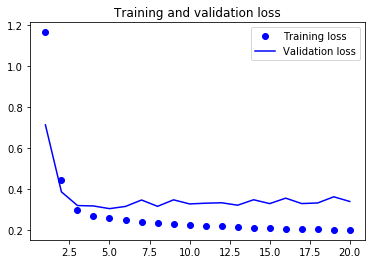

In [41]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
